# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

### Init

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
# create gdrive shortcut using url "https://drive.google.com/open?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL"  -- note the open which is required to allow to create shortcut
#!unzip -d '/content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment' 'Project_data.zip'

Mounted at /content/gdrive


In [2]:
#cd /content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment

In [3]:
#!wget "https://drive.google.com/open?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL"
#!wget -O Project_data.zip "$file_share_link"
#!ls -lrt
#!df -h "/content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data"

In [4]:
import pandas as pd
import numpy as np
import os
import datetime
import os
import matplotlib.pyplot as plt
from skimage import io
import glob
import cv2

from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50

We set the random seed so that the results don't vary drastically.

In [5]:
#from google.colab.patches import cv_imread

In [6]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

### Inspect Data & View Images

In [7]:
# Setup the paths
DATA_DIR='/content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/'
DATA_DIR_TRAIN = DATA_DIR + 'train/'
DATA_DIR_VAL = DATA_DIR + 'val/'

In [8]:
# Lets inspect the train data and see how many videos are available per label
train_df = pd.read_csv(DATA_DIR + 'train.csv', delimiter=';', header=None)
train_df.columns = ['name', 'type', 'label']
train_df.head()
train_df.groupby(by=['type', 'label'])['name'].count()

type                           label
Left Swipe_new_Left Swipe_new  0         40
Left_Swipe_new                 0         96
Right Swipe_new                1         34
Right_Swipe_new                1        103
Stop Gesture_new               2         37
Stop_new                       2         93
Thumbs Down_new                3         37
Thumbs Up_new                  4         36
Thumbs_Down_new                3        100
Thumbs_Up_new                  4         87
Name: name, dtype: int64

In [9]:
val_df = pd.read_csv(DATA_DIR + 'val.csv', delimiter=';', header=None)
val_df.columns = ['name', 'type', 'label']
val_df.head()
val_df.groupby(by=['type', 'label'])['name'].count()

type                           label
Left Swipe_new_Left Swipe_new  0         5
Left_Swipe_new                 0        13
Right Swipe_new                1        10
Right_Swipe_new                1        13
Stop Gesture_new               2         8
Stop_new                       2        14
Thumbs Down_new                3         9
Thumbs Up_new                  4         6
Thumbs_Down_new                3        12
Thumbs_Up_new                  4        10
Name: name, dtype: int64

In [10]:
train_df.head()

,name,type,label
0,WIN_20180925_17_08_43_Pro_Left_Swipe_new,Left_Swipe_new,0
1,WIN_20180925_17_18_28_Pro_Left_Swipe_new,Left_Swipe_new,0
2,WIN_20180925_17_18_56_Pro_Left_Swipe_new,Left_Swipe_new,0
3,WIN_20180925_17_19_51_Pro_Left_Swipe_new,Left_Swipe_new,0
4,WIN_20180925_17_20_14_Pro_Left_Swipe_new,Left_Swipe_new,0


In [11]:
train_doc = np.random.permutation(open(DATA_DIR + 'train.csv').readlines())
val_doc = np.random.permutation(open(DATA_DIR + 'val.csv').readlines())
#batch_size = 3 #experiment with the batch size  -- Moved below to Model Creation section

/content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/train/WIN_20180925_17_08_43_Pro_Left_Swipe_new/*


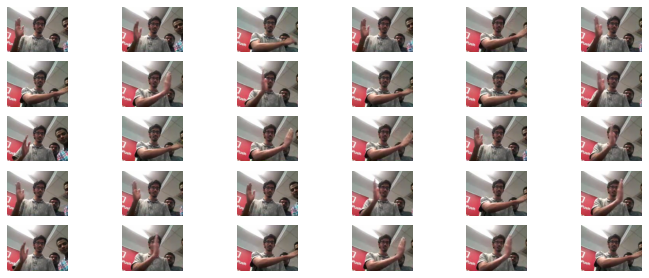

In [12]:
# Lets check the frames for a video

sample_img_path = os.path.join(DATA_DIR_TRAIN, train_df.iloc[0][0], '*')
print(sample_img_path)
sample_img_list = glob.glob(sample_img_path)
sample_img_list

plt.figure(figsize=(12, 30))
for k, file_name in enumerate(sample_img_list):
  ax = plt.subplot(len(sample_img_list), 6, k+1)
  plt.imshow(io.imread(file_name))
  plt.axis("off")

/content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/train/WIN_20180925_17_18_28_Pro_Left_Swipe_new/*


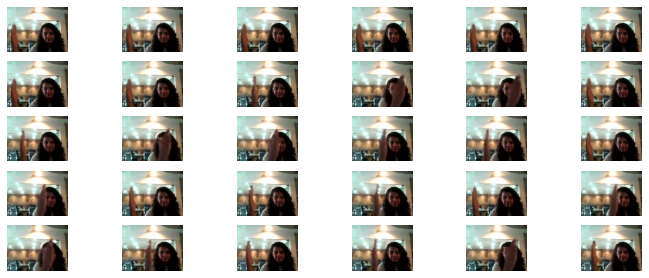

In [13]:
# And another video
sample_img_path = os.path.join(DATA_DIR_TRAIN, train_df.iloc[1][0], '*')
print(sample_img_path)
sample_img_list = glob.glob(sample_img_path)
sample_img_list

plt.figure(figsize=(12, 30))
for k, file_name in enumerate(sample_img_list):
  ax = plt.subplot(len(sample_img_list), 6, k+1)
  plt.imshow(io.imread(file_name))
  plt.axis("off")

/content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/train/WIN_20180925_17_18_56_Pro_Left_Swipe_new/*


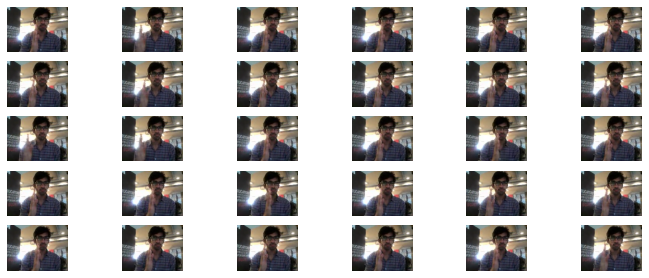

In [14]:
# And another video
sample_img_path = os.path.join(DATA_DIR_TRAIN, train_df.iloc[2][0], '*')
print(sample_img_path)
sample_img_list = glob.glob(sample_img_path)
sample_img_list

plt.figure(figsize=(12, 30))
for k, file_name in enumerate(sample_img_list):
  ax = plt.subplot(len(sample_img_list), 6, k+1)
  plt.imshow(io.imread(file_name))
  plt.axis("off")

(120, 160, 3) (120, 120, 3)


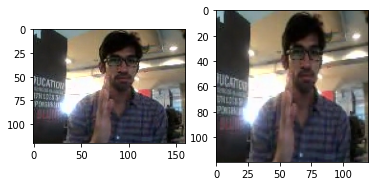

In [15]:
# lets try resize function from opencv and check for an image
i_img = io.imread(sample_img_list[0])
o_img = cv2.resize(i_img, (120, 120), interpolation = cv2.INTER_AREA)
print(i_img.shape, o_img.shape)

plt.subplot(1, 2, 1)
plt.imshow(i_img)

plt.subplot(1, 2, 2)
plt.imshow(o_img)

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [16]:
def generator(source_path, folder_list, o_batch_size, img_idx = [0, 4, 8, 12, 16, 20, 24, 28], p_preprocess_input=False):
    #print( '\nSource path = ', source_path, '; batch size =', o_batch_size)

     # img_idx create a list of image numbers you want to use for a particular video. Keep it as a parameter so that 
     # can experiment with different number of frames per video
    
    img_cnt = len(img_idx) # This is the number of frames per video we will use

    # Image size is fixed at 120x120 since the images are of 2 sizes different sizes - 360x360 or 120x160. 
    # Choose the lower res since if we try to extrapolate, the noise added will be higher. 
    # Plus a smaller image res means that our model will train faster
    width = 120 # Width of the image. 
    height = 120 # Height of the image

    while True:
        batch_size = o_batch_size # set the batch size depending on what has been passed

        t = np.random.permutation(folder_list)
        #print('folder count = ', len(t))
        
        num_batches = int(len(t)/batch_size)# calculate the number of batches
        #print('num_batches = ', num_batches)

        folders_remanining = (len(t) - num_batches*batch_size) # folders that will be left after creating batches
        #print('\ntotalFolders=', len(t), 'num_batches = ', num_batches, 'folders_remanining=', folders_remanining)

        for batch in range(num_batches): # we iterate over the number of batches
            
            batch_data = np.zeros((batch_size, img_cnt, width, height, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output

            for folder in range(batch_size): # iterate over the batch_size
                
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                #print('### folder=', folder, ' folder_index=', (folder + (batch*batch_size)), '########')
                
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    
                    image = io.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    # Cropping is not done since it may cause important feature to be lost. 
                    image = cv2.resize(image, (width, height), interpolation = cv2.INTER_AREA)

                    if p_preprocess_input: #if resnet50 is being used then it needs to be pre-processed to convert image from RGB to BGR
                      image = preprocess_input(image)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


        #write the code for the remaining data points which are left after full batches
        if folders_remanining > 0: 
          batch = 1 # we will have only one batch remaning

          start_from = num_batches * batch_size # calculate the index where the batching process ended

          end_at = len(t) # calculate the index of the last folder

          batch_size = folders_remanining # set the batch_size
          
          #print('\nPending - folders_remanining', folders_remanining, 'start_from=',start_from, 'end_at=', end_at, 'batch_size=', batch_size)

          batch_data = np.zeros((batch_size, img_cnt, width, height, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
          batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
          #for batch*batch_size+1 in range(len(t)): # iterate over the batch_size

          folder_idx = 0 # since now the folder starts at the index where the previous batch creation ended, we need a new variable to index the batch_data and batch_labels
          for folder in range(start_from, end_at): # iterate using start and end

              imgs = os.listdir(source_path+'/'+ t[folder].split(';')[0]) # read all the images in the folder now identified by folder index
              
              for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                  #print('### folder=', folder, '########')

                  image = io.imread(source_path+'/'+ t[folder].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                  
                  #crop the images and resize them. Note that the images are of 2 different shape 
                  #and the conv3D will throw error if the inputs in a batch have different shapes

                  image = cv2.resize(image, (width, height), interpolation = cv2.INTER_AREA)
                  
                  batch_data[folder_idx,idx,:,:,0] = image[:,:,0]/255#normalise and feed in the image
                  batch_data[folder_idx,idx,:,:,1] = image[:,:,1]/255#normalise and feed in the image
                  batch_data[folder_idx,idx,:,:,2] = image[:,:,2]/255#normalise and feed in the image
                  
              batch_labels[folder_idx, int(t[folder].strip().split(';')[2])] = 1
              folder_idx = folder_idx + 1
          yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [17]:
# Test the generator for different batch_sizes, uncomment the prints in generator program before runnung the following to see that 
# all folders are considered 

train_doc_sample = train_doc[0:11]
batch_size = 3
img_idx = [0]
gen = generator(DATA_DIR_TRAIN, train_doc_sample, batch_size, img_idx, p_preprocess_input=False)
#train_doc_sample

In [18]:
next(gen)
next(gen)
next(gen)
next(gen)

(array([[[[[0.53235292, 0.51274508, 0.4735294 ],
           [0.53333336, 0.50784314, 0.47450981],
           [0.53725493, 0.50588238, 0.47843137],
           ...,
           [0.43823528, 0.43431371, 0.40196079],
           [0.43725491, 0.43333334, 0.40392157],
           [0.43921569, 0.43529412, 0.41176471]],
 
          [[0.51372552, 0.49019608, 0.45490196],
           [0.51764709, 0.49019608, 0.46078432],
           [0.51568627, 0.48431373, 0.46078432],
           ...,
           [0.44215685, 0.44117647, 0.40686274],
           [0.43921569, 0.43529412, 0.40784314],
           [0.43921569, 0.43529412, 0.41176471]],
 
          [[0.50980395, 0.47843137, 0.44313726],
           [0.51372552, 0.48627451, 0.45490196],
           [0.51764709, 0.49411765, 0.46666667],
           ...,
           [0.44215685, 0.43823528, 0.41470587],
           [0.43921569, 0.43529412, 0.41176471],
           [0.43921569, 0.43529412, 0.41176471]],
 
          ...,
 
          [[0.09019608, 0.10980392, 0.047058

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [19]:
curr_dt_time = datetime.datetime.now()
train_path = DATA_DIR_TRAIN
val_path = DATA_DIR_VAL
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


### Check data created by the generator

In [20]:
# Check that the left over are also served 
train_generator = generator(train_path, train_doc[0:3], 2, p_preprocess_input=True)

for i in range(7):
  batch_data, batch_labels = next(train_generator)
  print(batch_data.shape)

(2, 8, 120, 120, 3)
(1, 8, 120, 120, 3)
(2, 8, 120, 120, 3)
(1, 8, 120, 120, 3)
(2, 8, 120, 120, 3)
(1, 8, 120, 120, 3)
(2, 8, 120, 120, 3)


In [21]:
## check if normalization worked 
batch_data[0][0]

array([[[-0.2360353 , -0.23148628, -0.13109805],
        [-0.23113334, -0.23050588, -0.11835294],
        [-0.22034903, -0.22658432, -0.09678432],
        ...,
        [-0.28015295, -0.31972158, -0.39482352],
        [-0.29583922, -0.32854509, -0.40462744],
        [-0.32034904, -0.3550157 , -0.42913726]],

       [[-0.22819217, -0.23540784, -0.12521569],
        [-0.22721177, -0.23246667, -0.11835294],
        [-0.22034903, -0.22658432, -0.09678432],
        ...,
        [-0.14289805, -0.18638824, -0.25756863],
        [-0.2115255 , -0.24619216, -0.32031372],
        [-0.25368237, -0.288349  , -0.3624706 ]],

       [[-0.22623138, -0.24521177, -0.12717648],
        [-0.21936864, -0.23638824, -0.11443137],
        [-0.21250589, -0.23050588, -0.09580392],
        ...,
        [ 0.0012196 , -0.04423137, -0.11541177],
        [-0.05270197, -0.09717254, -0.16737255],
        [-0.09485883, -0.14129019, -0.20756863]],

       ...,

       [[-0.27132943, -0.32168236, -0.26933333],
        [-0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


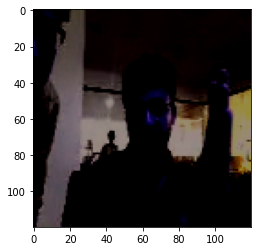

In [22]:
## check if the image is still the same after transformations
plt.imshow(batch_data[0][0])

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [23]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv2D, Conv3D, MaxPooling3D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras import utils


### Model Functions

In [24]:
import pandas as pd
def print_best_epoc(history):  
  df = pd.DataFrame(history.history)
  print(df.iloc[df['val_categorical_accuracy'].idxmax()])

In [25]:
def train_model(curr_dt_time, batch_size, train_doc_sample, val_doc_sample, 
                num_epochs, p_preprocess_input, model, min_lr=0.00001, img_idx = [0, 4, 8, 12, 16, 20, 24, 28], 
                save_model=False, model_name='model'):

  num_train_sequences = len(train_doc_sample)
  print('# training sequences =', num_train_sequences)
  
  num_val_sequences = len(val_doc_sample)
  print('# validation sequences =', num_val_sequences)

  if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
  else:
      steps_per_epoch = (num_train_sequences//batch_size) + 1

  if (num_val_sequences%batch_size) == 0:
      validation_steps = int(num_val_sequences/batch_size)
  else:
      validation_steps = (num_val_sequences//batch_size) + 1

  train_generator = generator(DATA_DIR_TRAIN, train_doc_sample, batch_size, img_idx, p_preprocess_input=p_preprocess_input)
  val_generator = generator(DATA_DIR_VAL, val_doc_sample, batch_size, img_idx, p_preprocess_input=p_preprocess_input)


  # setup params
  LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=min_lr)# write the REducelronplateau code here

  if save_model:
    model_name = DATA_DIR + 'model_output/' + model_name + '_' + str(curr_dt_time).replace(' ','').replace(':','_')
      
    if not os.path.exists(model_name):
        os.mkdir(model_name)
            
    filepath = model_name + '/' + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, 
                                save_weights_only=False, mode='auto')

    callbacks_list = [checkpoint, LR]
  else:
    callbacks_list = [LR]

  # calculate steps per epoch and val steps
  if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
  else:
      steps_per_epoch = (num_train_sequences//batch_size) + 1

  if (num_val_sequences%batch_size) == 0:
      validation_steps = int(num_val_sequences/batch_size)
  else:
      validation_steps = (num_val_sequences//batch_size) + 1
  
  # model.fit
  history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
  
  return history

In [26]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Building CNN2D + RNN
* As per the instructions in the live session on Assignment, while building the RNN model, transfer learning using pre-trained models can be used. We will be using ResNet50

## Resnet50

### Experiment 1
Model - Resnet50-CNN-RNN-GRU16,8  
Resnet50 - No layers trainable  
CNN - 64 Conv + 16 Conv  
GRU - 16 units + 8 units  
FC - softmax   

In [ ]:
#Cause an Error to Prevent running the experiments

In [ ]:
frames_used = 8
resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(120, 120, 3))

# Lock all layers of resnet 
resnet.trainable = False

cnn = Sequential([resnet])
cnn.add(Conv2D(64, (2,2), strides=(1,1)))
cnn.add(Conv2D(16, (3,3), strides=(1,1)))
cnn.add(Flatten())

model = Sequential()
model.add(TimeDistributed(cnn, input_shape=(frames_used, 120, 120, 3)))
model.add(GRU(16, input_shape=(None, frames_used, 256), return_sequences=True))
model.add(GRU(8))
model.add(Dense(5, activation='softmax'))

optimiser = 'Adam'#write your optimizer   ## Check with RMSprop or others
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

#utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

94781440/94765736 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 8, 16)            24121296  
 ibuted)                                                         
                                                                 
 gru (GRU)                   (None, 8, 16)             1632      
                                                                 
 gru_1 (GRU)                 (None, 8)                 624       
                                                                 
 dense (Dense)               (None, 5)                 45        
                                                                 
Total params: 24,123,597
Trainable params: 535,885
Non-trainable params: 23,587,712
_________________________________________________________________
None


In [ ]:
#train_doc_sample = train_doc #train_doc[0:32]
#val_doc_sample = val_doc #val_doc[0:32]
curr_dt_time = datetime.datetime.now()

history = train_model(curr_dt_time, min_lr=0.00001, batch_size=32, train_doc_sample=train_doc, val_doc_sample=val_doc, num_epochs=30, p_preprocess_input=True, model=model)

print (model.summary())


# training sequences = 663
# validation sequences = 100
Epoch 1/30
21/21 [==============================] - 57s 2s/step - loss: 1.6302 - categorical_accuracy: 0.2262 - val_loss: 1.5979 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - 28s 1s/step - loss: 1.5870 - categorical_accuracy: 0.2232 - val_loss: 1.5754 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - 28s 1s/step - loss: 1.5430 - categorical_accuracy: 0.2489 - val_loss: 1.5183 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 4/30
21/21 [==============================] - 26s 1s/step - loss: 1.5345 - categorical_accuracy: 0.3213 - val_loss: 1.5369 - val_categorical_accuracy: 0.3200 - lr: 0.0010
Epoch 5/30
21/21 [==============================] - 28s 1s/step - loss: 1.4969 - categorical_accuracy: 0.3107 - val_loss: 1.4757 - val_categorical_accuracy: 0.3500 - lr: 0.0010
Epoch 6/30
21/21 [==============================] - 27s 1s/

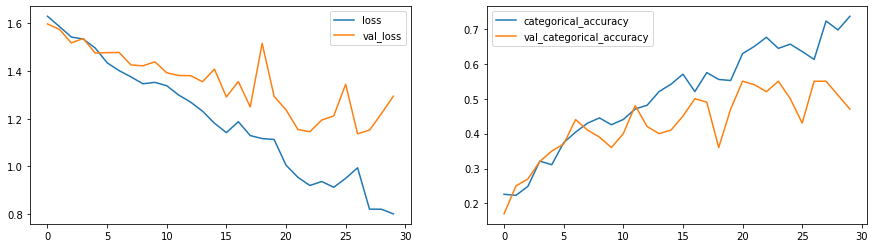

In [ ]:
plot(history)

### Experiment 2
Model - Resnet50-CNN-RNN-GRU16,8  
Resnet50 - Last 5 layers trainable  
CNN - 64 Conv + 16 Conv  
GRU - 16 units + 8 units  
FC - softmax   

In [ ]:
frames_used = 8
resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(120, 120, 3))

# Keep the last 5 layers of resnet trainable so that it learns our images
for layer in resnet.layers[:-5]:
    layer.trainable=False

cnn = Sequential([resnet])
cnn.add(Conv2D(64, (2,2), strides=(1,1)))
cnn.add(Conv2D(16, (3,3), strides=(1,1)))
cnn.add(Flatten())

model = Sequential()
model.add(TimeDistributed(cnn, input_shape=(frames_used, 120, 120, 3)))
model.add(GRU(16, input_shape=(None, frames_used, 256), return_sequences=True))
model.add(GRU(8))
model.add(Dense(5, activation='softmax'))

optimiser = 'Adam'#write your optimizer   ## Check with RMSprop or others
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDis  (None, 8, 16)            24121296  
 tributed)                                                       
                                                                 
 gru_2 (GRU)                 (None, 8, 16)             1632      
                                                                 
 gru_3 (GRU)                 (None, 8)                 624       
                                                                 
 dense_1 (Dense)             (None, 5)                 45        
                                                                 
Total params: 24,123,597
Trainable params: 1,590,605
Non-trainable params: 22,532,992
_________________________________________________________________
None


In [ ]:
curr_dt_time = datetime.datetime.now()

history = train_model(curr_dt_time, min_lr=0.00001, batch_size=32, train_doc_sample=train_doc, val_doc_sample=val_doc, num_epochs=30, p_preprocess_input=True, model=model)

print('-----------------------')
print_best_epoc(history)

# training sequences = 663
# validation sequences = 100
Epoch 1/30
21/21 [==============================] - 37s 1s/step - loss: 1.6716 - categorical_accuracy: 0.1825 - val_loss: 1.6347 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - 29s 1s/step - loss: 1.6160 - categorical_accuracy: 0.2066 - val_loss: 1.6205 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - 28s 1s/step - loss: 1.6091 - categorical_accuracy: 0.2217 - val_loss: 1.6287 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 4/30
21/21 [==============================] - 27s 1s/step - loss: 1.6144 - categorical_accuracy: 0.1976 - val_loss: 1.6101 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 5/30
21/21 [==============================] - 28s 1s/step - loss: 1.6105 - categorical_accuracy: 0.2021 - val_loss: 1.6080 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 6/30
21/21 [==============================] - 29s 1s/

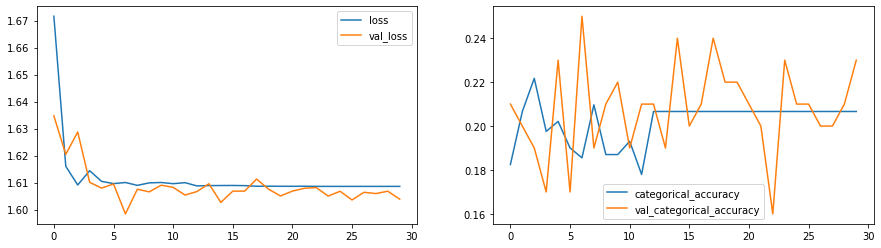

In [ ]:
plot(history)

In [ ]:
curr_dt_time = datetime.datetime.now()

history = train_model(curr_dt_time, min_lr=0.00001, batch_size=32, train_doc_sample=train_doc, val_doc_sample=val_doc, num_epochs=30, p_preprocess_input=True, model=model)

print('-----------------------')
print_best_epoc(history)

### Experiment 3
Model - Resnet50-CNN-RNN-GRU32,16  
Resnet50 - Last 5 layers trainable  
CNN - 64 Conv + 16 Conv  
GRU - 32 units + 16 units  
FC - softmax   

In [ ]:
frames_used = 8
resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(120, 120, 3))

# Lock all layers of resnet 
resnet.trainable = False

cnn = Sequential([resnet])
cnn.add(Conv2D(64, (2,2), strides=(1,1)))
cnn.add(Conv2D(16, (3,3), strides=(1,1)))
cnn.add(Flatten())

model = Sequential()
model.add(TimeDistributed(cnn, input_shape=(frames_used, 120, 120, 3)))
model.add(GRU(32, input_shape=(None, frames_used, 256), return_sequences=True))
model.add(GRU(16))
model.add(Dense(5, activation='softmax'))

optimiser = 'Adam'#write your optimizer   ## Check with RMSprop or others
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDis  (None, 8, 16)            24121296  
 tributed)                                                       
                                                                 
 gru_4 (GRU)                 (None, 8, 32)             4800      
                                                                 
 gru_5 (GRU)                 (None, 16)                2400      
                                                                 
 dense_2 (Dense)             (None, 5)                 85        
                                                                 
Total params: 24,128,581
Trainable params: 540,869
Non-trainable params: 23,587,712
_________________________________________________________________
None


In [ ]:
curr_dt_time = datetime.datetime.now()

history = train_model(curr_dt_time, min_lr=0.00001, batch_size=32, train_doc_sample=train_doc, val_doc_sample=val_doc, num_epochs=50, p_preprocess_input=True, model=model)

print('-----------------------')
print_best_epoc(history)

# training sequences = 663
# validation sequences = 100
Epoch 1/50
21/21 [==============================] - 36s 1s/step - loss: 1.7073 - categorical_accuracy: 0.1750 - val_loss: 1.5671 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - 28s 1s/step - loss: 1.5098 - categorical_accuracy: 0.2956 - val_loss: 1.4970 - val_categorical_accuracy: 0.3600 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - 28s 1s/step - loss: 1.4437 - categorical_accuracy: 0.3484 - val_loss: 1.4512 - val_categorical_accuracy: 0.3800 - lr: 0.0010
Epoch 4/50
21/21 [==============================] - 27s 1s/step - loss: 1.4407 - categorical_accuracy: 0.3363 - val_loss: 1.4111 - val_categorical_accuracy: 0.3600 - lr: 0.0010
Epoch 5/50
21/21 [==============================] - 28s 1s/step - loss: 1.4021 - categorical_accuracy: 0.3741 - val_loss: 1.4750 - val_categorical_accuracy: 0.3600 - lr: 0.0010
Epoch 6/50
21/21 [==============================] - 28s 1s/

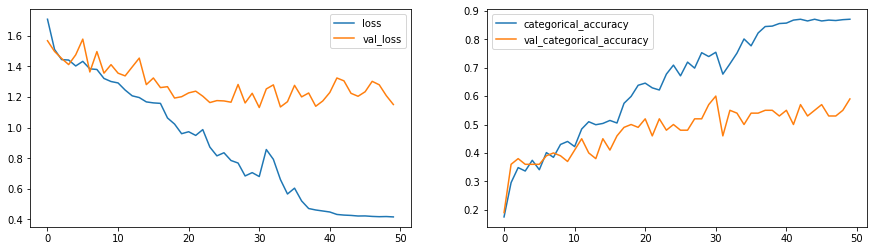

In [ ]:
plot(history)

### Experiment 4
Model - Resnet50-CNN-RNN-GRU32,16  
Resnet50 - Last 5 layers trainable  
CNN - 64 Conv + 16 Conv  
GRU - 32 units + 16 units  
FC - softmax   

frames_used = 12

In [ ]:
img_idx_tmp = [0, 3, 6, 9, 12, 15, 17, 19, 21, 24, 27, 29]
frames_used = len(img_idx_tmp)
print('frames_used=',frames_used)

resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(120, 120, 3))

# Lock all layers of resnet 
resnet.trainable = False

cnn = Sequential([resnet])
cnn.add(Conv2D(64, (2,2), strides=(1,1)))
cnn.add(Conv2D(16, (3,3), strides=(1,1)))
cnn.add(Flatten())

model = Sequential()
model.add(TimeDistributed(cnn, input_shape=(frames_used, 120, 120, 3)))
model.add(GRU(32, input_shape=(None, frames_used, 256), return_sequences=True))
model.add(GRU(16))
model.add(Dense(5, activation='softmax'))

optimiser = 'Adam'#write your optimizer   ## Check with RMSprop or others
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

frames_used= 12
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, 12, 16)           24121296  
 tributed)                                                       
                                                                 
 gru_6 (GRU)                 (None, 12, 32)            4800      
                                                                 
 gru_7 (GRU)                 (None, 16)                2400      
                                                                 
 dense_3 (Dense)             (None, 5)                 85        
                                                                 
Total params: 24,128,581
Trainable params: 540,869
Non-trainable params: 23,587,712
_________________________________________________________________
None


In [ ]:
curr_dt_time = datetime.datetime.now()

history = train_model(curr_dt_time, min_lr=0.00000001, batch_size=32, train_doc_sample=train_doc,
                      val_doc_sample=val_doc, num_epochs=50, 
                      p_preprocess_input=True, model=model, img_idx=img_idx_tmp)

print('-----------------------')
print_best_epoc(history)

# training sequences = 663
# validation sequences = 100
Epoch 1/50
21/21 [==============================] - 57s 2s/step - loss: 1.6700 - categorical_accuracy: 0.1584 - val_loss: 1.5955 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - 43s 2s/step - loss: 1.6060 - categorical_accuracy: 0.2202 - val_loss: 1.5914 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - 43s 2s/step - loss: 1.5712 - categorical_accuracy: 0.3107 - val_loss: 1.4953 - val_categorical_accuracy: 0.3700 - lr: 0.0010
Epoch 4/50
21/21 [==============================] - 39s 2s/step - loss: 1.5056 - categorical_accuracy: 0.3228 - val_loss: 1.5010 - val_categorical_accuracy: 0.3300 - lr: 0.0010
Epoch 5/50
21/21 [==============================] - 41s 2s/step - loss: 1.4526 - categorical_accuracy: 0.3801 - val_loss: 1.4321 - val_categorical_accuracy: 0.3800 - lr: 0.0010
Epoch 6/50
21/21 [==============================] - 43s 2s/

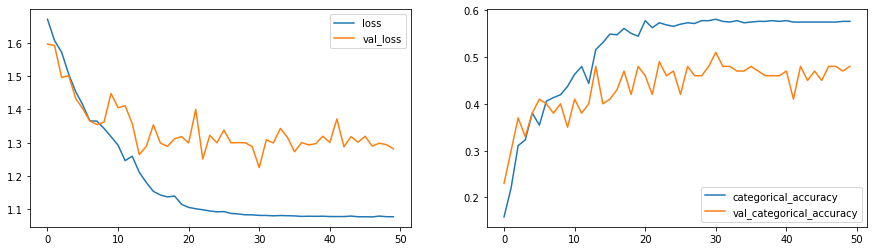

In [ ]:
plot(history)

### Experiment 5

In [ ]:
img_idx_tmp = [i for i in range(0, 30, 2)]
frames_used = len(img_idx_tmp)
print('frames_used=',frames_used)

resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(120, 120, 3))

# Lock all layers of resnet 
resnet.trainable = False

cnn = Sequential([resnet])
cnn.add(Conv2D(64, (2,2), strides=(1,1)))
cnn.add(Conv2D(16, (3,3), strides=(1,1)))
cnn.add(Flatten())

model = Sequential()
model.add(TimeDistributed(cnn, input_shape=(frames_used, 120, 120, 3)))
model.add(GRU(32, input_shape=(None, frames_used, 256), return_sequences=True))
model.add(GRU(16))
model.add(Dense(5, activation='softmax'))

optimiser = 'Adam'#write your optimizer   ## Check with RMSprop or others
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

frames_used= 15
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 15, 16)           24121296  
 tributed)                                                       
                                                                 
 gru_8 (GRU)                 (None, 15, 32)            4800      
                                                                 
 gru_9 (GRU)                 (None, 16)                2400      
                                                                 
 dense_4 (Dense)             (None, 5)                 85        
                                                                 
Total params: 24,128,581
Trainable params: 540,869
Non-trainable params: 23,587,712
_________________________________________________________________
None


In [ ]:
curr_dt_time = datetime.datetime.now()

history = train_model(curr_dt_time, min_lr=0.00000001, batch_size=32, train_doc_sample=train_doc,
                      val_doc_sample=val_doc, num_epochs=50, 
                      p_preprocess_input=True, model=model, img_idx=img_idx_tmp)

print('-----------------------')
print_best_epoc(history)

# training sequences = 663
# validation sequences = 100
Epoch 1/50
21/21 [==============================] - 66s 3s/step - loss: 1.6605 - categorical_accuracy: 0.2157 - val_loss: 1.5621 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - 51s 3s/step - loss: 1.5349 - categorical_accuracy: 0.2881 - val_loss: 1.4485 - val_categorical_accuracy: 0.3900 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - 52s 3s/step - loss: 1.4391 - categorical_accuracy: 0.3620 - val_loss: 1.4255 - val_categorical_accuracy: 0.3800 - lr: 0.0010
Epoch 4/50
21/21 [==============================] - 49s 2s/step - loss: 1.3908 - categorical_accuracy: 0.3665 - val_loss: 1.4259 - val_categorical_accuracy: 0.3900 - lr: 0.0010
Epoch 5/50
21/21 [==============================] - 51s 3s/step - loss: 1.3804 - categorical_accuracy: 0.3906 - val_loss: 1.3753 - val_categorical_accuracy: 0.3800 - lr: 0.0010
Epoch 6/50
21/21 [==============================] - 52s 3s/

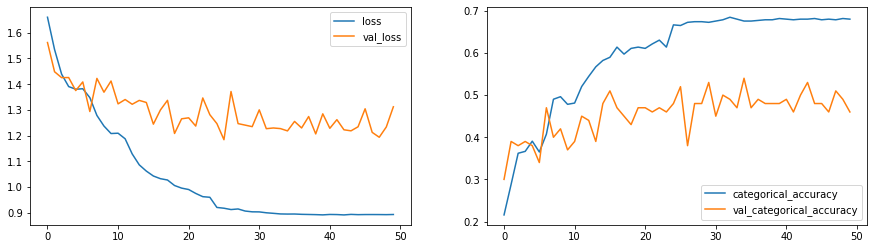

In [ ]:
plot(history)

### Experiment 6

In [ ]:
img_idx_tmp = [0, 3, 6, 9, 12, 15, 17, 19, 21, 24, 27, 29]
frames_used = len(img_idx_tmp)
print('frames_used=',frames_used)

resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(120, 120, 3))

# Lock all layers of resnet 
resnet.trainable = False

cnn = Sequential([resnet])
cnn.add(Conv2D(64, (2,2), strides=(1,1)))
cnn.add(Conv2D(16, (3,3), strides=(1,1)))
cnn.add(Flatten())

model = Sequential()
model.add(TimeDistributed(cnn, input_shape=(frames_used, 120, 120, 3)))
model.add(GRU(32, input_shape=(None, frames_used, 256), return_sequences=True))
model.add(GRU(16))
model.add(Dense(5, activation='softmax'))

optimiser = 'Adam'#write your optimizer   ## Check with RMSprop or others
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

frames_used= 12
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_5 (TimeDis  (None, 12, 16)           24121296  
 tributed)                                                       
                                                                 
 gru_10 (GRU)                (None, 12, 32)            4800      
                                                                 
 gru_11 (GRU)                (None, 16)                2400      
                                                                 
 dense_5 (Dense)             (None, 5)                 85        
                                                                 
Total params: 24,128,581
Trainable params: 540,869
Non-trainable params: 23,587,712
_________________________________________________________________
None


In [ ]:
curr_dt_time = datetime.datetime.now()

history = train_model(curr_dt_time, min_lr=0.00000001, batch_size=64, train_doc_sample=train_doc,
                      val_doc_sample=val_doc, num_epochs=30, 
                      p_preprocess_input=True, model=model, img_idx=img_idx_tmp)

print('-----------------------')
print_best_epoc(history)

# training sequences = 663
# validation sequences = 100
Epoch 1/30
11/11 [==============================] - 55s 4s/step - loss: 1.7453 - categorical_accuracy: 0.2262 - val_loss: 1.5840 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/30
11/11 [==============================] - 42s 4s/step - loss: 1.5593 - categorical_accuracy: 0.2609 - val_loss: 1.5127 - val_categorical_accuracy: 0.3200 - lr: 0.0010
Epoch 3/30
11/11 [==============================] - 42s 4s/step - loss: 1.4830 - categorical_accuracy: 0.3710 - val_loss: 1.4595 - val_categorical_accuracy: 0.3900 - lr: 0.0010
Epoch 4/30
11/11 [==============================] - 40s 4s/step - loss: 1.4394 - categorical_accuracy: 0.3529 - val_loss: 1.4908 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 5/30
11/11 [==============================] - 43s 4s/step - loss: 1.4003 - categorical_accuracy: 0.3816 - val_loss: 1.3912 - val_categorical_accuracy: 0.3700 - lr: 0.0010
Epoch 6/30
11/11 [==============================] - 42s 4s/

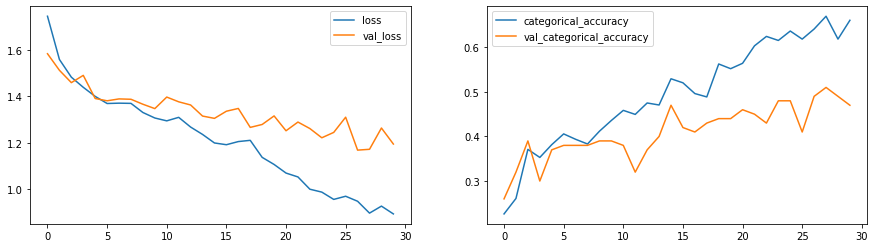

In [ ]:
plot(history)

### Experiment 7

In [ ]:
img_idx_tmp = [0, 3, 6, 9, 12, 15, 17, 19, 21, 24, 27, 29]
frames_used = len(img_idx_tmp)
print('frames_used=',frames_used)

resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(120, 120, 3))

# Keep the last 5 layers of resnet trainable so that it learns our images
for layer in resnet.layers[:-5]:
    layer.trainable=False

cnn = Sequential([resnet])
cnn.add(Conv2D(64, (2,2), strides=(1,1)))
cnn.add(Conv2D(16, (3,3), strides=(1,1)))
cnn.add(Flatten())

model = Sequential()
model.add(TimeDistributed(cnn, input_shape=(frames_used, 120, 120, 3)))
model.add(GRU(32, input_shape=(None, frames_used, 256), return_sequences=True))
model.add(GRU(16))
model.add(Dense(5, activation='softmax'))

optimiser = 'Adam'#write your optimizer   ## Check with RMSprop or others
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())  

frames_used= 12
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, 12, 16)           24121296  
 tributed)                                                       
                                                                 
 gru_12 (GRU)                (None, 12, 32)            4800      
                                                                 
 gru_13 (GRU)                (None, 16)                2400      
                                                                 
 dense_6 (Dense)             (None, 5)                 85        
                                                                 
Total params: 24,128,581
Trainable params: 1,595,589
Non-trainable params: 22,532,992
_________________________________________________________________
None


In [ ]:
curr_dt_time = datetime.datetime.now()

history = train_model(curr_dt_time, min_lr=0.00000001, batch_size=64, train_doc_sample=train_doc,
                      val_doc_sample=val_doc, num_epochs=30, 
                      p_preprocess_input=True, model=model, img_idx=img_idx_tmp)

print('-----------------------')
print_best_epoc(history)

# training sequences = 663
# validation sequences = 100
Epoch 1/30
11/11 [==============================] - 53s 4s/step - loss: 1.7014 - categorical_accuracy: 0.2081 - val_loss: 1.6490 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/30
11/11 [==============================] - 42s 4s/step - loss: 1.6078 - categorical_accuracy: 0.1885 - val_loss: 1.5919 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 3/30
11/11 [==============================] - 44s 4s/step - loss: 1.5733 - categorical_accuracy: 0.2232 - val_loss: 1.5560 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 4/30
11/11 [==============================] - 43s 4s/step - loss: 1.5170 - categorical_accuracy: 0.3514 - val_loss: 1.5406 - val_categorical_accuracy: 0.3300 - lr: 0.0010
Epoch 5/30
11/11 [==============================] - 44s 4s/step - loss: 1.4870 - categorical_accuracy: 0.3575 - val_loss: 1.4801 - val_categorical_accuracy: 0.3600 - lr: 0.0010
Epoch 6/30
11/11 [==============================] - 43s 4s/

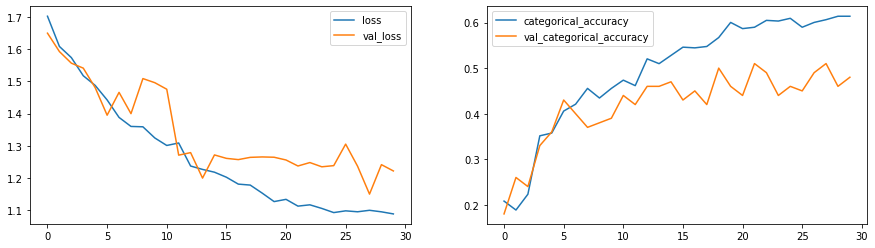

In [ ]:
plot(history)

### Experiment 8
Change in network and batch size = 32


In [ ]:
img_idx_tmp = [0, 3, 6, 9, 12, 15, 17, 19, 21, 24, 27, 29]
frames_used = len(img_idx_tmp)
print('frames_used=',frames_used)

resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(120, 120, 3))

# Keep the last 5 layers of resnet trainable so that it learns our images
for layer in resnet.layers[:-5]:
    layer.trainable=False

cnn = Sequential([resnet])
# cnn.add(Conv2D(64, (2,2), strides=(1,1)))
# cnn.add(Conv2D(16, (3,3), strides=(1,1)))

cnn.add(Conv2D(32, (3,3), strides=(1,1), padding='same'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D())
cnn.add(Conv2D(64, (3,3), strides=(1,1), padding='same'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D())
cnn.add(Conv2D(128, (3,3), strides=(1,1), padding='same'))
cnn.add(BatchNormalization())
cnn.add(Flatten())

model = Sequential()
model.add(TimeDistributed(cnn, input_shape=(frames_used, 120, 120, 3)))
model.add(GRU(32, input_shape=(None, frames_used, 256), return_sequences=True))
model.add(GRU(16))
model.add(Dense(5, activation='softmax'))

optimiser = 'Adam'#write your optimizer   ## Check with RMSprop or others
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())  

frames_used= 12
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_7 (TimeDis  (None, 12, 128)          24270816  
 tributed)                                                       
                                                                 
 gru_14 (GRU)                (None, 12, 32)            15552     
                                                                 
 gru_15 (GRU)                (None, 16)                2400      
                                                                 
 dense_7 (Dense)             (None, 5)                 85        
                                                                 
Total params: 24,288,853
Trainable params: 1,755,413
Non-trainable params: 22,533,440
_________________________________________________________________
None


In [ ]:
curr_dt_time = datetime.datetime.now()

history = train_model(curr_dt_time, min_lr=0.00000001, batch_size=32, train_doc_sample=train_doc,
                      val_doc_sample=val_doc, num_epochs=30, 
                      p_preprocess_input=True, model=model, img_idx=img_idx_tmp)

print('-----------------------')
print_best_epoc(history)

# training sequences = 663
# validation sequences = 100
Epoch 1/30
21/21 [==============================] - 52s 2s/step - loss: 1.3430 - categorical_accuracy: 0.4434 - val_loss: 1.5335 - val_categorical_accuracy: 0.3300 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - 45s 2s/step - loss: 1.1163 - categorical_accuracy: 0.5535 - val_loss: 1.7232 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - 43s 2s/step - loss: 1.0229 - categorical_accuracy: 0.6109 - val_loss: 1.8425 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 4/30
21/21 [==============================] - 45s 2s/step - loss: 0.9330 - categorical_accuracy: 0.6516 - val_loss: 2.1306 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 5/30
21/21 [==============================] - 42s 2s/step - loss: 0.8490 - categorical_accuracy: 0.6833 - val_loss: 2.1827 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 6/30
21/21 [==============================] - 43s 2s/

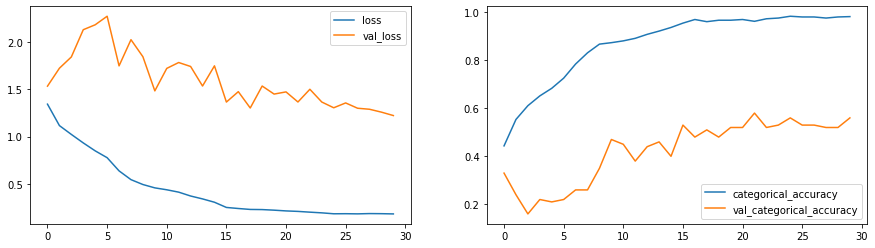

In [ ]:
plot(history)

### Experiment 9

In [ ]:
img_idx_tmp = [0, 3, 6, 9, 12, 15, 17, 19, 21, 24, 27, 29]
frames_used = len(img_idx_tmp)
print('frames_used=',frames_used)

resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(120, 120, 3))

# Keep the last 5 layers of resnet trainable so that it learns our images
for layer in resnet.layers[:-5]:
    layer.trainable=False

cnn = Sequential([resnet])
# cnn.add(Conv2D(64, (2,2), strides=(1,1)))
# cnn.add(Conv2D(16, (3,3), strides=(1,1)))

cnn.add(Conv2D(32, (3,3), strides=(1,1), padding='same'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D())
cnn.add(Conv2D(64, (3,3), strides=(1,1), padding='same'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D())
cnn.add(Conv2D(128, (3,3), strides=(1,1), padding='same'))
cnn.add(BatchNormalization())
cnn.add(Flatten())

model = Sequential()
model.add(TimeDistributed(cnn, input_shape=(frames_used, 120, 120, 3)))
model.add(GRU(32, input_shape=(None, frames_used, 256), return_sequences=True))
model.add(GRU(16))
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))

optimiser = 'Adam'#write your optimizer   ## Check with RMSprop or others
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())  

frames_used= 12
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDis  (None, 12, 128)          24270816  
 tributed)                                                       
                                                                 
 gru_16 (GRU)                (None, 12, 32)            15552     
                                                                 
 gru_17 (GRU)                (None, 16)                2400      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_8 (Dense)             (None, 5)                 85        
                                                                 
Total params: 24,288,853
Trainable params: 1,755,413
Non-trainable params: 22,533,440
_________________

In [ ]:
curr_dt_time = datetime.datetime.now()

history = train_model(curr_dt_time, min_lr=0.00000001, batch_size=32, train_doc_sample=train_doc,
                      val_doc_sample=val_doc, num_epochs=30, 
                      p_preprocess_input=True, model=model, img_idx=img_idx_tmp)

print('-----------------------')
print_best_epoc(history)

# training sequences = 663
# validation sequences = 100
Epoch 1/30
21/21 [==============================] - 52s 2s/step - loss: 1.4982 - categorical_accuracy: 0.3560 - val_loss: 1.6733 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - 43s 2s/step - loss: 1.3211 - categorical_accuracy: 0.4570 - val_loss: 1.6599 - val_categorical_accuracy: 0.1400 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - 42s 2s/step - loss: 1.2300 - categorical_accuracy: 0.5128 - val_loss: 1.4954 - val_categorical_accuracy: 0.4100 - lr: 0.0010
Epoch 4/30
21/21 [==============================] - 41s 2s/step - loss: 1.1885 - categorical_accuracy: 0.5234 - val_loss: 1.6354 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 5/30
21/21 [==============================] - 42s 2s/step - loss: 1.1085 - categorical_accuracy: 0.5716 - val_loss: 1.5488 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 6/30
21/21 [==============================] - 43s 2s/

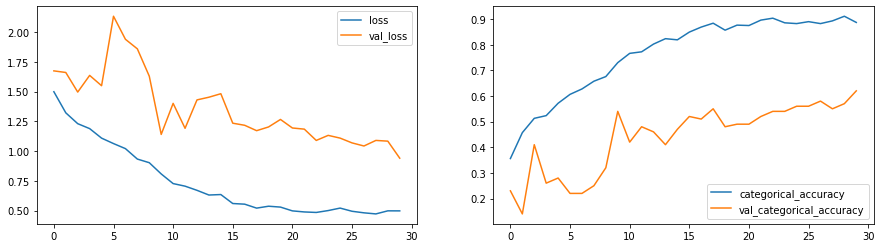

In [ ]:
plot(history)

### Experiment 10

In [ ]:
img_idx_tmp = [0, 3, 6, 9, 12, 15, 17, 19, 21, 24, 27, 29]
frames_used = len(img_idx_tmp)
print('frames_used=',frames_used)

resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(120, 120, 3))

# Keep the last 10 layers of resnet trainable so that it learns our images
for layer in resnet.layers[:-5]:
    layer.trainable=False

cnn = Sequential([resnet])
# cnn.add(Conv2D(64, (2,2), strides=(1,1)))
# cnn.add(Conv2D(16, (3,3), strides=(1,1)))

cnn.add(Conv2D(32, (3,3), strides=(1,1), padding='same'))
#cnn.add(BatchNormalization())
cnn.add(MaxPooling2D())
cnn.add(Conv2D(64, (3,3), strides=(1,1), padding='same'))
#cnn.add(BatchNormalization())
cnn.add(MaxPooling2D())
cnn.add(Conv2D(128, (3,3), strides=(1,1), padding='same'))
cnn.add(BatchNormalization())
cnn.add(Flatten())

model = Sequential()
model.add(TimeDistributed(cnn, input_shape=(frames_used, 120, 120, 3)))
model.add(GRU(128, input_shape=(None, frames_used, 256), return_sequences=False))
model.add(Dropout(0.25))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax'))


optimiser = 'Adam'#write your optimizer   ## Check with RMSprop or others
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())  

frames_used= 12
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_9 (TimeDis  (None, 12, 128)          24270432  
 tributed)                                                       
                                                                 
 gru_18 (GRU)                (None, 128)               99072     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 5)                 645       
                                     

In [ ]:
curr_dt_time = datetime.datetime.now()

history = train_model(curr_dt_time, min_lr=0.00000001, batch_size=32, train_doc_sample=train_doc,
                      val_doc_sample=val_doc, num_epochs=30, 
                      p_preprocess_input=True, model=model, img_idx=img_idx_tmp)

print('-----------------------')
print_best_epoc(history)

# training sequences = 663
# validation sequences = 100
Epoch 1/30
21/21 [==============================] - 50s 2s/step - loss: 1.4757 - categorical_accuracy: 0.3680 - val_loss: 1.6555 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - 45s 2s/step - loss: 1.2063 - categorical_accuracy: 0.5128 - val_loss: 1.6461 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - 43s 2s/step - loss: 1.1031 - categorical_accuracy: 0.5686 - val_loss: 1.5655 - val_categorical_accuracy: 0.4200 - lr: 0.0010
Epoch 4/30
21/21 [==============================] - 41s 2s/step - loss: 0.9415 - categorical_accuracy: 0.6501 - val_loss: 2.0206 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 5/30
21/21 [==============================] - 44s 2s/step - loss: 0.9171 - categorical_accuracy: 0.6320 - val_loss: 2.1694 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 6/30
21/21 [==============================] - 45s 2s/

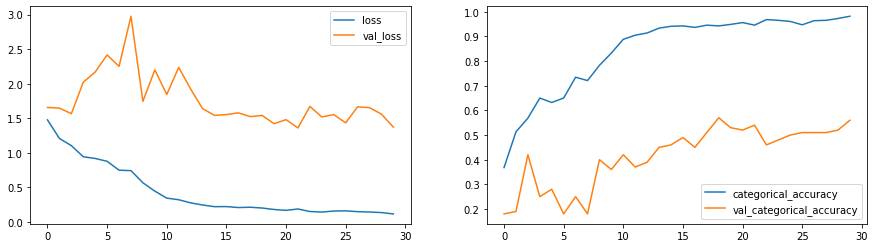

In [ ]:
plot(history)

### Experiment 11

In [ ]:
img_idx_tmp = [0, 3, 6, 9, 12, 15, 17, 19, 21, 24, 27, 29]
frames_used = len(img_idx_tmp)
print('frames_used=',frames_used)

resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(120, 120, 3))

# Keep the last 10 layers of resnet trainable so that it learns our images
for layer in resnet.layers[:-5]:
    layer.trainable=False

cnn = Sequential([resnet])
# cnn.add(Conv2D(64, (2,2), strides=(1,1)))
# cnn.add(Conv2D(16, (3,3), strides=(1,1)))

cnn.add(Conv2D(32, (3,3), strides=(1,1), padding='same'))
#cnn.add(BatchNormalization())
cnn.add(MaxPooling2D())
cnn.add(Conv2D(64, (3,3), strides=(1,1), padding='same'))
#cnn.add(BatchNormalization())
cnn.add(MaxPooling2D())
cnn.add(Conv2D(128, (3,3), strides=(1,1), padding='same'))
cnn.add(BatchNormalization())
cnn.add(Flatten())

model = Sequential()
model.add(TimeDistributed(cnn, input_shape=(frames_used, 120, 120, 3)))
model.add(GRU(128, input_shape=(None, frames_used, 256), return_sequences=False))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))


optimiser = 'Adam'#write your optimizer   ## Check with RMSprop or others
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())  

frames_used= 12
94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 12, 128)          24270432  
 ibuted)                                                         
                                                                 
 gru (GRU)                   (None, 128)               99072     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5) 

In [ ]:
curr_dt_time = datetime.datetime.now()

history = train_model(curr_dt_time, min_lr=0.00000001, batch_size=32, train_doc_sample=train_doc,
                      val_doc_sample=val_doc, num_epochs=30, 
                      p_preprocess_input=True, model=model, img_idx=img_idx_tmp)

print('-----------------------')
print_best_epoc(history)

# training sequences = 663
# validation sequences = 100
Epoch 1/30
21/21 [==============================] - 2758s 137s/step - loss: 1.6416 - categorical_accuracy: 0.3077 - val_loss: 1.7699 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - 50s 2s/step - loss: 1.4427 - categorical_accuracy: 0.4087 - val_loss: 1.6520 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - 50s 2s/step - loss: 1.3091 - categorical_accuracy: 0.4691 - val_loss: 1.8483 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 4/30
21/21 [==============================] - 48s 2s/step - loss: 1.2258 - categorical_accuracy: 0.5023 - val_loss: 1.5135 - val_categorical_accuracy: 0.3300 - lr: 0.0010
Epoch 5/30
21/21 [==============================] - 50s 2s/step - loss: 1.1913 - categorical_accuracy: 0.5324 - val_loss: 1.4890 - val_categorical_accuracy: 0.3600 - lr: 0.0010
Epoch 6/30
21/21 [==============================] - 50s

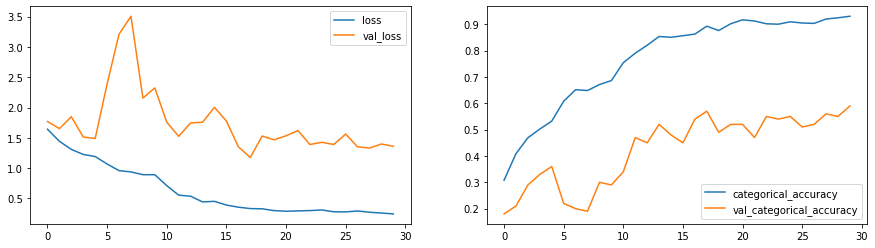

In [ ]:
plot(history)

### Experiment 12

In [ ]:
frames_used = 18
img_idx_tmp = np.round(np.linspace(0,29,frames_used)).astype(int)
print('frames_used=',frames_used, " img_idx_tmp=", img_idx_tmp)

resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(120, 120, 3))

# Keep the last 10 layers of resnet trainable so that it learns our images
for layer in resnet.layers[:-5]:
    layer.trainable=False

cnn = Sequential([resnet])
# cnn.add(Conv2D(64, (2,2), strides=(1,1)))
# cnn.add(Conv2D(16, (3,3), strides=(1,1)))

cnn.add(Conv2D(32, (3,3), strides=(1,1), padding='same'))
#cnn.add(BatchNormalization())
cnn.add(MaxPooling2D())
cnn.add(Conv2D(64, (3,3), strides=(1,1), padding='same'))
#cnn.add(BatchNormalization())
cnn.add(MaxPooling2D())
cnn.add(Conv2D(128, (3,3), strides=(1,1), padding='same'))
cnn.add(BatchNormalization())
cnn.add(Flatten())

model = Sequential()
model.add(TimeDistributed(cnn, input_shape=(frames_used, 120, 120, 3)))
model.add(GRU(64, input_shape=(None, frames_used, 256), return_sequences=False))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))


optimiser = 'Adam'#write your optimizer   ## Check with RMSprop or others
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())  

frames_used= 18  img_idx_tmp= [ 0  2  3  5  7  9 10 12 14 15 17 19 20 22 24 26 27 29]
94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_21 (TimeDi  (None, 18, 128)          24270432  
 stributed)                                                      
                                                                 
 gru_6 (GRU)                 (None, 64)                37248     
                                                                 
 dropout_16 (Dropout)        (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                  

In [ ]:
curr_dt_time = datetime.datetime.now()

history = train_model(curr_dt_time, min_lr=0.00000001, batch_size=32, train_doc_sample=train_doc,
                      val_doc_sample=val_doc, num_epochs=30, 
                      p_preprocess_input=True, model=model, img_idx=img_idx_tmp)

print('-----------------------')
print_best_epoc(history)

# training sequences = 663
# validation sequences = 100
Epoch 1/30
21/21 [==============================] - 78s 3s/step - loss: 1.7281 - categorical_accuracy: 0.2775 - val_loss: 1.9417 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - 70s 3s/step - loss: 1.4778 - categorical_accuracy: 0.3876 - val_loss: 1.6921 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - 66s 3s/step - loss: 1.4629 - categorical_accuracy: 0.3922 - val_loss: 2.0378 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 4/30
21/21 [==============================] - 61s 3s/step - loss: 1.4182 - categorical_accuracy: 0.4419 - val_loss: 1.4409 - val_categorical_accuracy: 0.3800 - lr: 0.0010
Epoch 5/30
21/21 [==============================] - 64s 3s/step - loss: 1.3100 - categorical_accuracy: 0.4811 - val_loss: 1.7851 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 6/30
21/21 [==============================] - 73s 4s/

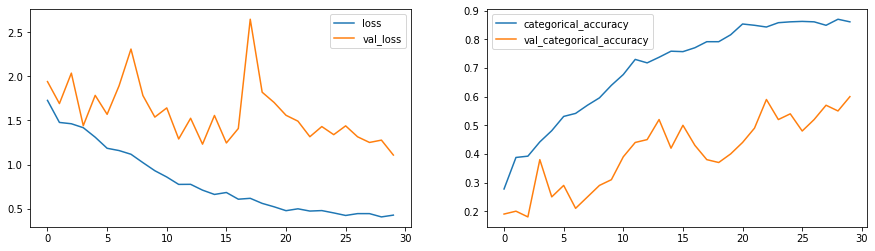

In [ ]:
plot(history)

### Experiment 13

In [ ]:
frames_used = 18
img_idx_tmp = np.round(np.linspace(0,29,frames_used)).astype(int)
print('frames_used=',frames_used, " img_idx_tmp=", img_idx_tmp)

resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(120, 120, 3))

# Keep the last 10 layers of resnet trainable so that it learns our images
for layer in resnet.layers[:-5]:
    layer.trainable=False

cnn = Sequential([resnet])
# cnn.add(Conv2D(64, (2,2), strides=(1,1)))
# cnn.add(Conv2D(16, (3,3), strides=(1,1)))

cnn.add(Conv2D(32, (3,3), strides=(1,1), padding='same'))
#cnn.add(BatchNormalization())
cnn.add(MaxPooling2D())
cnn.add(Conv2D(64, (3,3), strides=(1,1), padding='same'))
#cnn.add(BatchNormalization())
cnn.add(MaxPooling2D())
cnn.add(Conv2D(128, (3,3), strides=(1,1), padding='same'))
cnn.add(BatchNormalization())
cnn.add(Flatten())

model = Sequential()
model.add(TimeDistributed(cnn, input_shape=(frames_used, 120, 120, 3)))
model.add(GRU(64, input_shape=(None, frames_used, 256), return_sequences=False))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax'))


optimiser = 'Adam'#write your optimizer   ## Check with RMSprop or others
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())  

frames_used= 18  img_idx_tmp= [ 0  2  3  5  7  9 10 12 14 15 17 19 20 22 24 26 27 29]
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDis  (None, 18, 128)          24270432  
 tributed)                                                       
                                                                 
 gru_2 (GRU)                 (None, 64)                37248     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None

In [ ]:
curr_dt_time = datetime.datetime.now()

history = train_model(curr_dt_time, min_lr=0.00000001, batch_size=32, train_doc_sample=train_doc,
                      val_doc_sample=val_doc, num_epochs=20, 
                      p_preprocess_input=True, model=model, img_idx=img_idx_tmp)

print('-----------------------')
print_best_epoc(history)

# training sequences = 663
# validation sequences = 100
Epoch 1/20
21/21 [==============================] - 83s 4s/step - loss: 1.5429 - categorical_accuracy: 0.3379 - val_loss: 1.8114 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - 75s 4s/step - loss: 1.2656 - categorical_accuracy: 0.4917 - val_loss: 1.7660 - val_categorical_accuracy: 0.3100 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - 75s 4s/step - loss: 1.1506 - categorical_accuracy: 0.5385 - val_loss: 1.8697 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 4/20
21/21 [==============================] - 79s 4s/step - loss: 1.0202 - categorical_accuracy: 0.6094 - val_loss: 1.6769 - val_categorical_accuracy: 0.3500 - lr: 0.0010
Epoch 5/20
21/21 [==============================] - 74s 4s/step - loss: 0.9364 - categorical_accuracy: 0.6229 - val_loss: 1.5704 - val_categorical_accuracy: 0.3300 - lr: 0.0010
Epoch 6/20
21/21 [==============================] - 74s 4s/

In [ ]:
curr_dt_time = datetime.datetime.now()

history = train_model(curr_dt_time, min_lr=0.00000001, batch_size=32, train_doc_sample=train_doc,
                      val_doc_sample=val_doc, num_epochs=10, 
                      p_preprocess_input=True, model=model, img_idx=img_idx_tmp)

print('-----------------------')
print_best_epoc(history)

# training sequences = 663
# validation sequences = 100
Epoch 1/10
21/21 [==============================] - 76s 4s/step - loss: 0.1903 - categorical_accuracy: 0.9517 - val_loss: 1.5432 - val_categorical_accuracy: 0.5200 - lr: 4.0000e-05
Epoch 2/10
21/21 [==============================] - 77s 4s/step - loss: 0.1685 - categorical_accuracy: 0.9548 - val_loss: 1.4652 - val_categorical_accuracy: 0.5600 - lr: 4.0000e-05
Epoch 3/10
21/21 [==============================] - 76s 4s/step - loss: 0.1767 - categorical_accuracy: 0.9608 - val_loss: 1.5259 - val_categorical_accuracy: 0.5200 - lr: 4.0000e-05
Epoch 4/10
21/21 [==============================] - 73s 4s/step - loss: 0.1689 - categorical_accuracy: 0.9668 - val_loss: 1.7207 - val_categorical_accuracy: 0.4800 - lr: 4.0000e-05
Epoch 5/10
21/21 [==============================] - 76s 4s/step - loss: 0.1444 - categorical_accuracy: 0.9713 - val_loss: 1.5793 - val_categorical_accuracy: 0.5600 - lr: 4.0000e-05
Epoch 6/10
21/21 [=====================

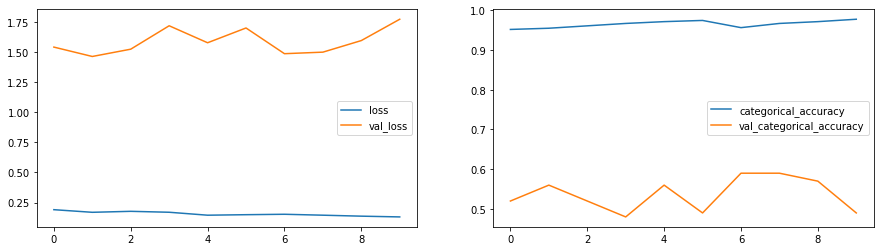

In [ ]:
plot(history)

### Experiment 14

In [ ]:
frames_used = 18
img_idx_tmp = np.round(np.linspace(0,29,frames_used)).astype(int)
print('frames_used=',frames_used, " img_idx_tmp=", img_idx_tmp)

resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(120, 120, 3))

# Keep the last 10 layers of resnet trainable so that it learns our images
for layer in resnet.layers[:-5]:
    layer.trainable=False

cnn = Sequential([resnet])
# cnn.add(Conv2D(64, (2,2), strides=(1,1)))
# cnn.add(Conv2D(16, (3,3), strides=(1,1)))

cnn.add(Conv2D(32, (3,3), strides=(1,1), padding='same'))
#cnn.add(BatchNormalization())
cnn.add(MaxPooling2D())
cnn.add(Conv2D(64, (3,3), strides=(1,1), padding='same'))
#cnn.add(BatchNormalization())
cnn.add(MaxPooling2D())
cnn.add(Conv2D(128, (3,3), strides=(1,1), padding='same'))
cnn.add(BatchNormalization())
cnn.add(Flatten())

model = Sequential()
model.add(TimeDistributed(cnn, input_shape=(frames_used, 120, 120, 3)))
model.add(GRU(128, input_shape=(None, frames_used, 256), return_sequences=False))
model.add(Dropout(0.25))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax'))


optimiser = 'Adam'#write your optimizer   ## Check with RMSprop or others
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())  

frames_used= 18  img_idx_tmp= [ 0  2  3  5  7  9 10 12 14 15 17 19 20 22 24 26 27 29]
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, 18, 128)          24270432  
 tributed)                                                       
                                                                 
 gru_3 (GRU)                 (None, 128)               99072     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None

In [ ]:
curr_dt_time = datetime.datetime.now()

history = train_model(curr_dt_time, min_lr=0.00000001, batch_size=32, train_doc_sample=train_doc,
                      val_doc_sample=val_doc, num_epochs=20, 
                      p_preprocess_input=True, model=model, img_idx=img_idx_tmp)

print('-----------------------')
print_best_epoc(history)

# training sequences = 663
# validation sequences = 100
Epoch 1/20
21/21 [==============================] - 86s 4s/step - loss: 1.4184 - categorical_accuracy: 0.3967 - val_loss: 1.9081 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - 75s 4s/step - loss: 1.1936 - categorical_accuracy: 0.5339 - val_loss: 2.2234 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - 76s 4s/step - loss: 1.0738 - categorical_accuracy: 0.5897 - val_loss: 2.6572 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 4/20
21/21 [==============================] - 73s 4s/step - loss: 1.0244 - categorical_accuracy: 0.6063 - val_loss: 1.9024 - val_categorical_accuracy: 0.3300 - lr: 0.0010
Epoch 5/20
21/21 [==============================] - 76s 4s/step - loss: 0.9295 - categorical_accuracy: 0.6395 - val_loss: 2.3442 - val_categorical_accuracy: 0.3500 - lr: 0.0010
Epoch 6/20
21/21 [==============================] - 76s 4s/

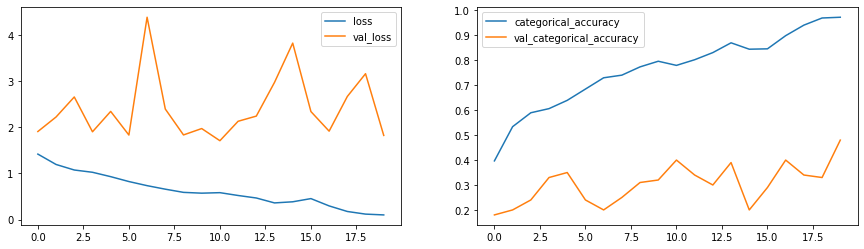

In [ ]:
plot(history)

### Experiment 15

In [ ]:
img_idx_tmp = [0, 3, 6, 9, 12, 15, 17, 19, 21, 24, 27, 29]
frames_used = len(img_idx_tmp)
print('frames_used=',frames_used)

resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(120, 120, 3))
for layer in resnet.layers[:-10]:
    layer.trainable=False

model=Sequential()
model.add(TimeDistributed(resnet,input_shape=(frames_used,120,120,3)))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.4))

model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.4))

model.add(TimeDistributed(Flatten()))


model.add(GRU(128))
model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(5, activation='softmax'))

optimiser = 'Adam'#write your optimizer   ## Check with RMSprop or others
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())  

frames_used= 12
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 12, 4, 4, 2048)   23587712  
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 12, 4, 4, 128)    2359424   
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 12, 4, 4, 128)    512       
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 12, 4, 4, 128)    147584    
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, 1

In [ ]:
curr_dt_time = datetime.datetime.now()

history = train_model(curr_dt_time, min_lr=0.000000001, batch_size=25, train_doc_sample=train_doc,
                      val_doc_sample=val_doc, num_epochs=50, 
                      p_preprocess_input=False, model=model, img_idx=img_idx_tmp)

print('-----------------------')
print_best_epoc(history)

# training sequences = 663
# validation sequences = 100
Epoch 1/50
27/27 [==============================] - 61s 2s/step - loss: 1.7784 - categorical_accuracy: 0.2142 - val_loss: 1.6811 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - 50s 2s/step - loss: 1.5665 - categorical_accuracy: 0.3002 - val_loss: 2.3916 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/50
27/27 [==============================] - 50s 2s/step - loss: 1.4570 - categorical_accuracy: 0.3394 - val_loss: 2.4738 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 4/50
27/27 [==============================] - 50s 2s/step - loss: 1.4083 - categorical_accuracy: 0.3560 - val_loss: 1.5969 - val_categorical_accuracy: 0.3300 - lr: 0.0010
Epoch 5/50
27/27 [==============================] - 50s 2s/step - loss: 1.3049 - categorical_accuracy: 0.3952 - val_loss: 1.3801 - val_categorical_accuracy: 0.3500 - lr: 0.0010
Epoch 6/50
27/27 [==============================] - 50s 2s/

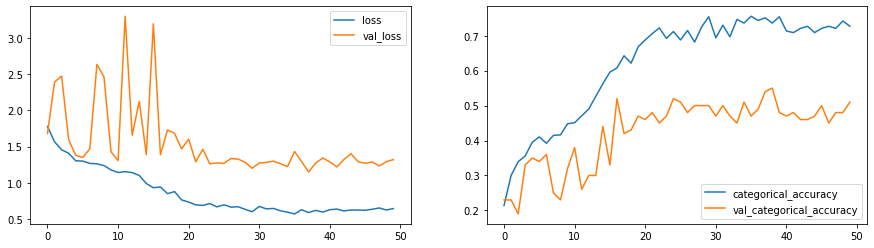

In [ ]:
plot(history)

### Experiment 16

In [ ]:
img_idx_tmp = [0, 3, 6, 9, 12, 15, 17, 19, 21, 24, 27, 29]
frames_used = len(img_idx_tmp)
print('frames_used=',frames_used)

resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(120, 120, 3))
for layer in resnet.layers[:-10]:
    layer.trainable=False

model=Sequential()
model.add(TimeDistributed(resnet,input_shape=(frames_used,120,120,3)))




model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.20))

model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.20))

model.add(TimeDistributed(Flatten()))


model.add(GRU(128))
model.add(Dropout(0.15))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.20))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(5, activation='softmax'))

optimiser = 'Adam'#write your optimizer   ## Check with RMSprop or others
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())  

frames_used= 12
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 12, 4, 4, 2048)   23587712  
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 12, 4, 4, 128)    2359424   
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 12, 4, 4, 128)    512       
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 12, 4, 4, 128)    147584    
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 1

In [ ]:
curr_dt_time = datetime.datetime.now()

history = train_model(curr_dt_time, min_lr=0.000000001, batch_size=25, train_doc_sample=train_doc,
                      val_doc_sample=val_doc, num_epochs=50, 
                      p_preprocess_input=False, model=model, img_idx=img_idx_tmp)

print('-----------------------')
print_best_epoc(history)

# training sequences = 663
# validation sequences = 100
Epoch 1/50
27/27 [==============================] - 61s 2s/step - loss: 2.4108 - categorical_accuracy: 0.2112 - val_loss: 1.7485 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - 50s 2s/step - loss: 2.3135 - categorical_accuracy: 0.2262 - val_loss: 1.6689 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/50
27/27 [==============================] - 50s 2s/step - loss: 2.1649 - categorical_accuracy: 0.2112 - val_loss: 1.6811 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 4/50
27/27 [==============================] - 50s 2s/step - loss: 1.9493 - categorical_accuracy: 0.2775 - val_loss: 1.6116 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 5/50
27/27 [==============================] - 50s 2s/step - loss: 1.8637 - categorical_accuracy: 0.3183 - val_loss: 1.5483 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 6/50
27/27 [==============================] - 51s 2s/

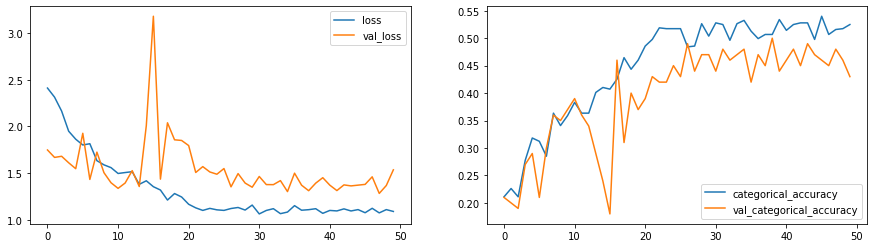

In [ ]:
plot(model.history)

### Experiment 17

In [ ]:
img_idx_tmp = [0, 3, 6, 9, 12, 15, 17, 19, 21, 24, 27, 29]
frames_used = len(img_idx_tmp)
print('frames_used=',frames_used)

resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(120, 120, 3))
for layer in resnet.layers[:-10]:
    layer.trainable=False

model=Sequential()
model.add(TimeDistributed(resnet,input_shape=(frames_used,120,120,3)))

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.20))


model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.20))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2),padding='same')))
model.add(Dropout(0.20))

model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), padding='same')))
model.add(Dropout(0.20))

model.add(TimeDistributed(Flatten()))


model.add(GRU(128))
model.add(Dropout(0.15))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.20))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(5, activation='softmax'))

optimiser = 'Adam'#write your optimizer   ## Check with RMSprop or others
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())  

frames_used= 12
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_28 (TimeDi  (None, 12, 4, 4, 2048)   23587712  
 stributed)                                                      
                                                                 
 time_distributed_29 (TimeDi  (None, 12, 4, 4, 32)     589856    
 stributed)                                                      
                                                                 
 time_distributed_30 (TimeDi  (None, 12, 4, 4, 32)     128       
 stributed)                                                      
                                                                 
 time_distributed_31 (TimeDi  (None, 12, 2, 2, 32)     0         
 stributed)                                                      
                                                                 
 dropout_17 (Dropout)        (None, 1

In [ ]:
curr_dt_time = datetime.datetime.now()

history = train_model(curr_dt_time, min_lr=0.00000000001, batch_size=25, train_doc_sample=train_doc,
                      val_doc_sample=val_doc, num_epochs=50, 
                      p_preprocess_input=True, model=model, img_idx=img_idx_tmp)

print('-----------------------')
print_best_epoc(history)

# training sequences = 663
# validation sequences = 100
Epoch 1/50
27/27 [==============================] - 62s 2s/step - loss: 2.4881 - categorical_accuracy: 0.1855 - val_loss: 1.6073 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - 52s 2s/step - loss: 2.2578 - categorical_accuracy: 0.2112 - val_loss: 1.6037 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 3/50
27/27 [==============================] - 51s 2s/step - loss: 2.1566 - categorical_accuracy: 0.2262 - val_loss: 1.5623 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 4/50
27/27 [==============================] - 51s 2s/step - loss: 2.0206 - categorical_accuracy: 0.2866 - val_loss: 1.5382 - val_categorical_accuracy: 0.3700 - lr: 0.0010
Epoch 5/50
27/27 [==============================] - 51s 2s/step - loss: 1.9904 - categorical_accuracy: 0.2579 - val_loss: 1.5439 - val_categorical_accuracy: 0.3100 - lr: 0.0010
Epoch 6/50
27/27 [==============================] - 51s 2s/

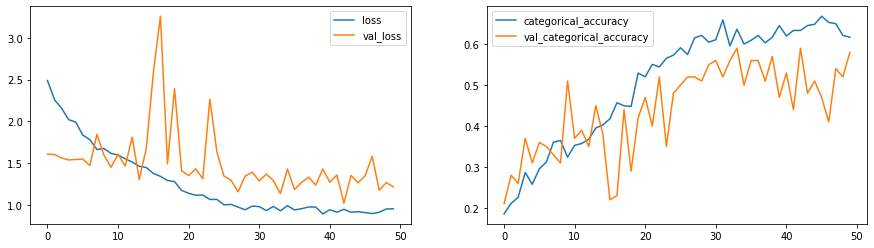

In [ ]:
plot(model.history)

### Experiment 18

In [ ]:
img_idx_tmp = [1, 3,5,7,9,11,13,15,17,19,21,23,25,27,29]
frames_used = len(img_idx_tmp)
print('frames_used=',frames_used)
resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(120, 120, 3))
for layer in resnet.layers[:-10]:
    layer.trainable=False

model=Sequential()
model.add(TimeDistributed(resnet,input_shape=(frames_used,120,120,3)))

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='elu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.20))

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='elu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.20))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='elu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2),padding='same')))
model.add(Dropout(0.20))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='elu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2),padding='same')))
model.add(Dropout(0.20))

model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='elu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), padding='same')))
model.add(Dropout(0.20))

model.add(TimeDistributed(Flatten()))


model.add(GRU(128))
model.add(Dropout(0.15))

model.add(Dense(128, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.20))

model.add(Dense(256, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.35))

model.add(Dense(5, activation='softmax'))

optimiser = 'Adam'#write your optimizer   ## Check with RMSprop or others
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary()) 

frames_used= 15
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_42 (TimeDi  (None, 15, 4, 4, 2048)   23587712  
 stributed)                                                      
                                                                 
 time_distributed_43 (TimeDi  (None, 15, 4, 4, 16)     294928    
 stributed)                                                      
                                                                 
 time_distributed_44 (TimeDi  (None, 15, 4, 4, 16)     64        
 stributed)                                                      
                                                                 
 time_distributed_45 (TimeDi  (None, 15, 2, 2, 16)     0         
 stributed)                                                      
                                                                 
 dropout_24 (Dropout)        (None, 1

In [ ]:
curr_dt_time = datetime.datetime.now()

history = train_model(curr_dt_time, min_lr=0.00000000001, batch_size=25, train_doc_sample=train_doc,
                      val_doc_sample=val_doc, num_epochs=50, 
                      p_preprocess_input=True, model=model, img_idx=img_idx_tmp)

print('-----------------------')
print_best_epoc(history)

# training sequences = 663
# validation sequences = 100
Epoch 1/50
27/27 [==============================] - 1095s 42s/step - loss: 2.2761 - categorical_accuracy: 0.2459 - val_loss: 1.7217 - val_categorical_accuracy: 0.3100 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - 66s 3s/step - loss: 1.9834 - categorical_accuracy: 0.2836 - val_loss: 1.9285 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/50
27/27 [==============================] - 65s 2s/step - loss: 1.7566 - categorical_accuracy: 0.3273 - val_loss: 1.5859 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 4/50
27/27 [==============================] - 65s 2s/step - loss: 1.7786 - categorical_accuracy: 0.3318 - val_loss: 1.8850 - val_categorical_accuracy: 0.3400 - lr: 0.0010
Epoch 5/50
27/27 [==============================] - 65s 2s/step - loss: 1.6609 - categorical_accuracy: 0.3318 - val_loss: 1.7045 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 6/50
27/27 [==============================] - 66s 

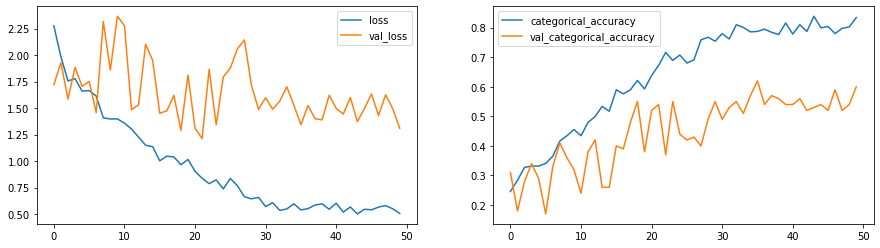

In [ ]:
plot(model.history)

## Custom CCN + RNN Model

### Experiment 50 - Custom Model

In [30]:
frames_used = 18
img_idx_tmp = np.round(np.linspace(0,29,frames_used)).astype(int)

print('frames_used=',frames_used)

model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                        input_shape=(frames_used, 120, 120, 3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))


model.add(TimeDistributed(Flatten()))


model.add(GRU(128, return_sequences=False))
model.add(Dropout(0.25))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax'))

optimiser = 'Adam'#write your optimizer   ## Check with RMSprop or others
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())  

frames_used= 18
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 18,

In [ ]:
curr_dt_time = datetime.datetime.now()

history = train_model(curr_dt_time, min_lr=0.00000001, batch_size=32, train_doc_sample=train_doc,
                      val_doc_sample=val_doc, num_epochs=30, 
                      p_preprocess_input=False, model=model, img_idx=img_idx_tmp)

print('-----------------------')
print_best_epoc(history)

# training sequences = 663
# validation sequences = 100
Epoch 1/30
21/21 [==============================] - 3520s 175s/step - loss: 1.4655 - categorical_accuracy: 0.3831 - val_loss: 1.9283 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - 57s 3s/step - loss: 1.0378 - categorical_accuracy: 0.5943 - val_loss: 2.1509 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - 57s 3s/step - loss: 0.8511 - categorical_accuracy: 0.6486 - val_loss: 2.0414 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 4/30
21/21 [==============================] - 55s 3s/step - loss: 0.7177 - categorical_accuracy: 0.7285 - val_loss: 1.9044 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 5/30
21/21 [==============================] - 57s 3s/step - loss: 0.5952 - categorical_accuracy: 0.7783 - val_loss: 1.9811 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 6/30
21/21 [==============================] - 57s

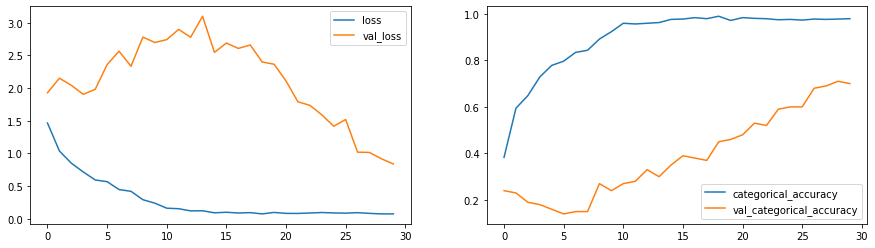

In [ ]:
plot(history)

### Experiment 51

In [ ]:
frames_used = 18
img_idx_tmp = np.round(np.linspace(0,29,frames_used)).astype(int)

print('frames_used=',frames_used)

model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                        input_shape=(frames_used, 120, 120, 3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))


model.add(TimeDistributed(Flatten()))


model.add(GRU(128, return_sequences=False))
model.add(Dropout(0.4))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(5, activation='softmax'))

optimiser = 'Adam'#write your optimizer   ## Check with RMSprop or others
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())  

frames_used= 18
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeDi  (None, 18, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 18, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 18, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 18, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 1

In [ ]:
curr_dt_time = datetime.datetime.now()

history = train_model(curr_dt_time, min_lr=0.00000001, batch_size=32, train_doc_sample=train_doc,
                      val_doc_sample=val_doc, num_epochs=30, 
                      p_preprocess_input=False, model=model, img_idx=img_idx_tmp)

print('-----------------------')
print_best_epoc(history)

# training sequences = 663
# validation sequences = 100
Epoch 1/30
21/21 [==============================] - 60s 3s/step - loss: 1.6287 - categorical_accuracy: 0.3062 - val_loss: 1.8250 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - 58s 3s/step - loss: 1.3033 - categorical_accuracy: 0.4359 - val_loss: 1.9801 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - 58s 3s/step - loss: 1.2775 - categorical_accuracy: 0.4691 - val_loss: 1.7198 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 4/30
21/21 [==============================] - 55s 3s/step - loss: 1.1264 - categorical_accuracy: 0.5294 - val_loss: 1.7486 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 5/30
21/21 [==============================] - 57s 3s/step - loss: 1.0030 - categorical_accuracy: 0.5882 - val_loss: 1.9110 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 6/30
21/21 [==============================] - 58s 3s/

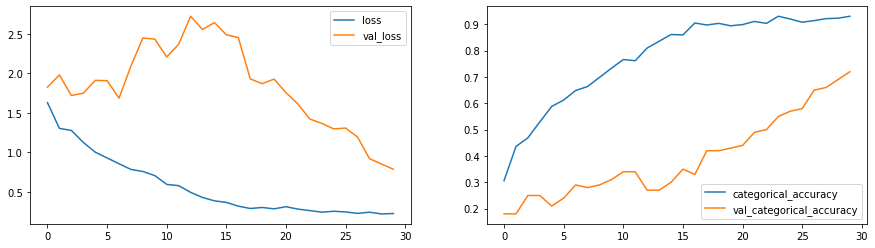

In [ ]:
plot(history)

### Experiment 52

In [ ]:
frames_used = 18
img_idx_tmp = np.round(np.linspace(0,29,frames_used)).astype(int)

print('frames_used=',frames_used)

model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                        input_shape=(frames_used, 120, 120, 3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))


model.add(TimeDistributed(Flatten()))


model.add(GRU(128, return_sequences=False))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))

optimiser = 'Adam'#write your optimizer   ## Check with RMSprop or others
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())  

frames_used= 18
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 18,

In [ ]:
curr_dt_time = datetime.datetime.now()

history = train_model(curr_dt_time, min_lr=0.00000001, batch_size=32, train_doc_sample=train_doc,
                      val_doc_sample=val_doc, num_epochs=50, 
                      p_preprocess_input=False, model=model, img_idx=img_idx_tmp)

print('-----------------------')
print_best_epoc(history)

# training sequences = 663
# validation sequences = 100
Epoch 1/50
21/21 [==============================] - 62s 3s/step - loss: 1.7909 - categorical_accuracy: 0.2805 - val_loss: 1.8061 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - 57s 3s/step - loss: 1.4339 - categorical_accuracy: 0.3906 - val_loss: 1.8372 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - 57s 3s/step - loss: 1.3271 - categorical_accuracy: 0.4449 - val_loss: 2.1404 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 4/50
21/21 [==============================] - 55s 3s/step - loss: 1.1850 - categorical_accuracy: 0.4902 - val_loss: 2.2026 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 5/50
21/21 [==============================] - 57s 3s/step - loss: 1.1295 - categorical_accuracy: 0.5385 - val_loss: 2.4678 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 6/50
21/21 [==============================] - 57s 3s/

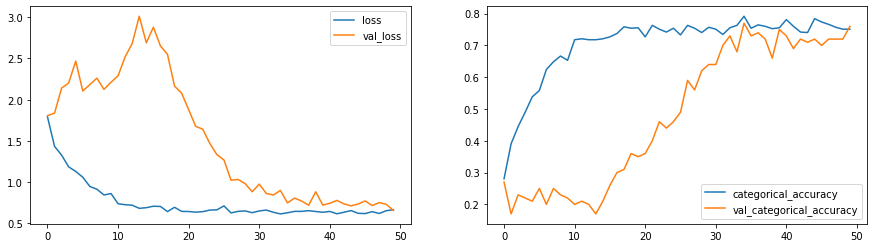

In [ ]:
plot(history)

### Experiment 53

In [ ]:
frames_used = 18
img_idx_tmp = np.round(np.linspace(0,29,frames_used)).astype(int)

print('frames_used=',frames_used)

model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                        input_shape=(frames_used, 120, 120, 3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))


model.add(GRU(128, return_sequences=False))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(5, activation='softmax'))

optimiser = 'Adam'#write your optimizer   ## Check with RMSprop or others
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())  

frames_used= 18
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeDi  (None, 18, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 18, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 18, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 18, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 1

In [ ]:
curr_dt_time = datetime.datetime.now()

history = train_model(curr_dt_time, min_lr=0.00000001, batch_size=32, train_doc_sample=train_doc,
                      val_doc_sample=val_doc, num_epochs=50, 
                      p_preprocess_input=False, model=model, img_idx=img_idx_tmp)

print('-----------------------')
print_best_epoc(history)

# training sequences = 663
# validation sequences = 100
Epoch 1/50
21/21 [==============================] - 61s 3s/step - loss: 1.6996 - categorical_accuracy: 0.3167 - val_loss: 1.9174 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - 57s 3s/step - loss: 1.3027 - categorical_accuracy: 0.4570 - val_loss: 2.1231 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - 57s 3s/step - loss: 1.1897 - categorical_accuracy: 0.5339 - val_loss: 2.2694 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 4/50
21/21 [==============================] - 55s 3s/step - loss: 1.0752 - categorical_accuracy: 0.5566 - val_loss: 2.1424 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 5/50
21/21 [==============================] - 57s 3s/step - loss: 0.9108 - categorical_accuracy: 0.6456 - val_loss: 2.1430 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 6/50
21/21 [==============================] - 58s 3s/

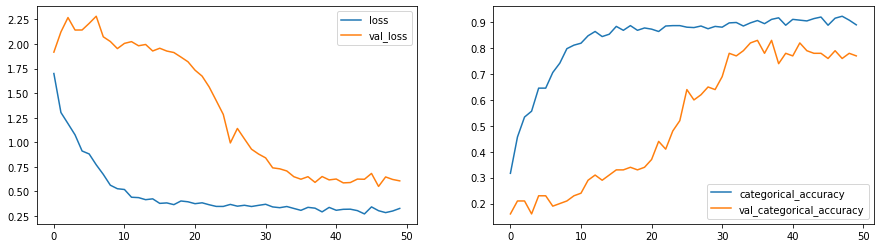

In [ ]:
plot(history)

### Experiment 54

In [ ]:
frames_used = 18
img_idx_tmp = np.round(np.linspace(0,29,frames_used)).astype(int)

print('frames_used=',frames_used)

model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                        input_shape=(frames_used, 120, 120, 3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))


model.add(GRU(128, return_sequences=False))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(5, activation='softmax'))

optimiser = 'Adam'#write your optimizer   ## Check with RMSprop or others
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())  

frames_used= 18
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_29 (TimeDi  (None, 18, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_30 (TimeDi  (None, 18, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_31 (TimeDi  (None, 18, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_32 (TimeDi  (None, 18, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_33 (TimeDi  (None, 1

In [ ]:
curr_dt_time = datetime.datetime.now()

history = train_model(curr_dt_time, min_lr=0.00000001, batch_size=20, train_doc_sample=train_doc,
                      val_doc_sample=val_doc, num_epochs=50, 
                      p_preprocess_input=False, model=model, img_idx=img_idx_tmp)

print('-----------------------')
print_best_epoc(history)

# training sequences = 663
# validation sequences = 100
Epoch 1/50
34/34 [==============================] - 60s 2s/step - loss: 1.7687 - categorical_accuracy: 0.2836 - val_loss: 1.9555 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/50
34/34 [==============================] - 57s 2s/step - loss: 1.3839 - categorical_accuracy: 0.4284 - val_loss: 2.2964 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/50
34/34 [==============================] - 57s 2s/step - loss: 1.2707 - categorical_accuracy: 0.4781 - val_loss: 2.2927 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 4/50
34/34 [==============================] - 58s 2s/step - loss: 1.1622 - categorical_accuracy: 0.5113 - val_loss: 2.3551 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 5/50
34/34 [==============================] - 57s 2s/step - loss: 1.0847 - categorical_accuracy: 0.5551 - val_loss: 2.2659 - val_categorical_accuracy: 0.3300 - lr: 0.0010
Epoch 6/50
34/34 [==============================] - 57s 2s/

In [ ]:
plot(history)

### Experiment 55

In [ ]:
frames_used = 18
img_idx_tmp = np.round(np.linspace(0,29,frames_used)).astype(int)

print('frames_used=',frames_used)

model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                        input_shape=(frames_used, 120, 120, 3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.3))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.3))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.3))

model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.3))

model.add(TimeDistributed(Flatten()))


model.add(GRU(128, return_sequences=False))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(5, activation='softmax'))

optimiser = 'Adam'#write your optimizer   ## Check with RMSprop or others
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())  

frames_used= 18
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 18,

In [ ]:
curr_dt_time = datetime.datetime.now()

history = train_model(curr_dt_time, min_lr=0.00000001, batch_size=32, train_doc_sample=train_doc,
                      val_doc_sample=val_doc, num_epochs=50, 
                      p_preprocess_input=False, model=model, img_idx=img_idx_tmp)

print('-----------------------')
print_best_epoc(history)

# training sequences = 663
# validation sequences = 100
Epoch 1/50
21/21 [==============================] - 62s 3s/step - loss: 1.8193 - categorical_accuracy: 0.2428 - val_loss: 1.9134 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - 57s 3s/step - loss: 1.5338 - categorical_accuracy: 0.3092 - val_loss: 2.1355 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - 57s 3s/step - loss: 1.3554 - categorical_accuracy: 0.4087 - val_loss: 2.3994 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 4/50
21/21 [==============================] - 55s 3s/step - loss: 1.2543 - categorical_accuracy: 0.4419 - val_loss: 2.3224 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 5/50
21/21 [==============================] - 57s 3s/step - loss: 1.2022 - categorical_accuracy: 0.5158 - val_loss: 2.4880 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 6/50
21/21 [==============================] - 57s 3s/

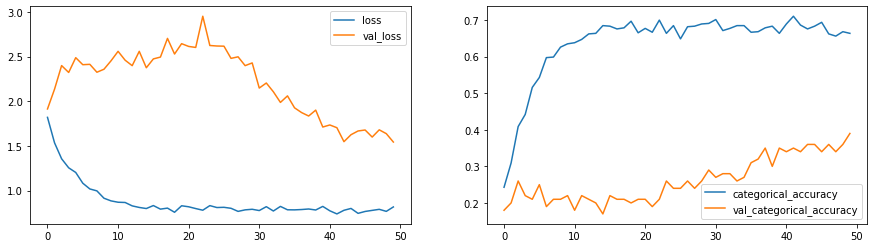

In [ ]:
plot(history)

### Final Model as per Experiment 54 with save on 

In [29]:
frames_used = 18
img_idx_tmp = np.round(np.linspace(0,29,frames_used)).astype(int)

print('frames_used=',frames_used)

model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                        input_shape=(frames_used, 120, 120, 3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))


model.add(GRU(128, return_sequences=False))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(5, activation='softmax'))

optimiser = 'Adam'#write your optimizer   ## Check with RMSprop or others
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())  

frames_used= 18
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 18,

In [30]:
curr_dt_time = datetime.datetime.now()

history = train_model(curr_dt_time, min_lr=0.00000001, batch_size=20, train_doc_sample=train_doc,
                      val_doc_sample=val_doc, num_epochs=50, 
                      p_preprocess_input=False, model=model, img_idx=img_idx_tmp, save_model=True, model_name='Custom_Exp54')

print('-----------------------')
print_best_epoc(history)

# training sequences = 663
# validation sequences = 100
Epoch 1/50
34/34 [==============================] - ETA: 0s - loss: 1.7591 - categorical_accuracy: 0.2971  
Epoch 00001: val_categorical_accuracy improved from -inf to 0.24000, saving model to /content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/model_output/Custom_Exp54_2022-01-2512_10_34.233937/model-00001-1.75906-0.29713-1.86652-0.24000.h5
34/34 [==============================] - 3618s 109s/step - loss: 1.7591 - categorical_accuracy: 0.2971 - val_loss: 1.8665 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/50
34/34 [==============================] - ETA: 0s - loss: 1.3877 - categorical_accuracy: 0.3997
Epoch 00002: val_categorical_accuracy did not improve from 0.24000
34/34 [==============================] - 57s 2s/step - loss: 1.3877 - categorical_accuracy: 0.3997 - val_loss: 2.9663 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/50
34/34 [==============================] - ETA: 0s - l

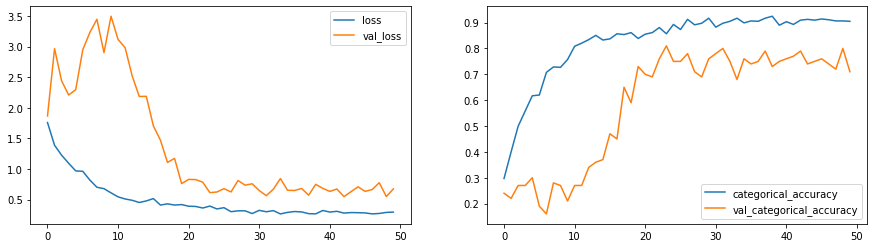

In [31]:
plot(history)

## MobileNetV2 Model

### Experiment 70 - MobileNetV2

In [40]:
from keras.applications.mobilenet_v2 import MobileNetV2

In [ ]:
frames_used = 18
img_idx_tmp = np.round(np.linspace(0,29,frames_used)).astype(int)

print('frames_used=',frames_used)

mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(120, 120, 3))

for layer in mobilenetv2.layers[:-10]:
    layer.trainable=False

cnn = Sequential([mobilenetv2])
cnn.add(Flatten())

model = Sequential()
model.add(TimeDistributed(cnn, input_shape=(frames_used, 120, 120, 3)))
model.add(GRU(128, return_sequences=False))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(5, activation='softmax'))


optimiser = 'Adam'#write your optimizer   ## Check with RMSprop or others
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())  

frames_used= 18
9420800/9406464 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 18, 20480)        2257984   
 stributed)                                                      
                                                                 
 gru_1 (GRU)                 (None, 128)               7914240   
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 5)   

In [ ]:
curr_dt_time = datetime.datetime.now()

history = train_model(curr_dt_time, min_lr=0.00000001, batch_size=32, train_doc_sample=train_doc,
                      val_doc_sample=val_doc, num_epochs=30, 
                      p_preprocess_input=False, model=model, img_idx=img_idx_tmp)

print('-----------------------')
print_best_epoc(history)

# training sequences = 663
# validation sequences = 100
Epoch 1/30
21/21 [==============================] - 64s 3s/step - loss: 1.6480 - categorical_accuracy: 0.3379 - val_loss: 1.5702 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - 57s 3s/step - loss: 1.1810 - categorical_accuracy: 0.5173 - val_loss: 1.7332 - val_categorical_accuracy: 0.3100 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - 57s 3s/step - loss: 0.9163 - categorical_accuracy: 0.6456 - val_loss: 1.7944 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 4/30
21/21 [==============================] - 55s 3s/step - loss: 0.6971 - categorical_accuracy: 0.7195 - val_loss: 1.9540 - val_categorical_accuracy: 0.3500 - lr: 0.0010
Epoch 5/30
21/21 [==============================] - 57s 3s/step - loss: 0.5670 - categorical_accuracy: 0.7753 - val_loss: 1.8895 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 6/30
21/21 [==============================] - 58s 3s/

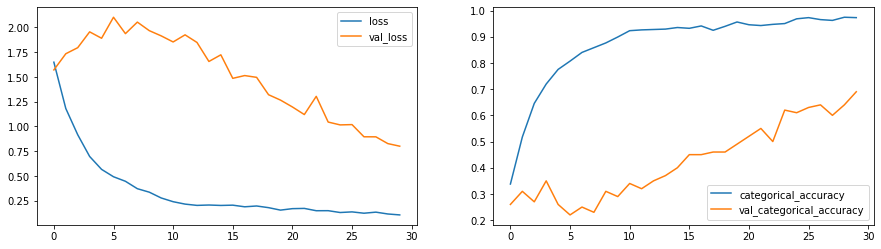

In [ ]:
plot(history)

### Experiment 71

In [ ]:
frames_used = 18
img_idx_tmp = np.round(np.linspace(0,29,frames_used)).astype(int)

print('frames_used=',frames_used)

mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(120, 120, 3))

for layer in mobilenetv2.layers[:-20]:
    layer.trainable=False

cnn = Sequential([mobilenetv2])
cnn.add(Flatten())

model = Sequential()
model.add(TimeDistributed(cnn, input_shape=(frames_used, 120, 120, 3)))
model.add(GRU(128, return_sequences=False))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(5, activation='softmax'))


optimiser = 'Adam'#write your optimizer   ## Check with RMSprop or others
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())  

frames_used= 18
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_19 (TimeDi  (None, 18, 20480)        2257984   
 stributed)                                                      
                                                                 
 gru_4 (GRU)                 (None, 128)               7914240   
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               16512     
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 5)                 645       
                                      

In [ ]:
curr_dt_time = datetime.datetime.now()

history = train_model(curr_dt_time, min_lr=0.00000001, batch_size=32, train_doc_sample=train_doc,
                      val_doc_sample=val_doc, num_epochs=50, 
                      p_preprocess_input=False, model=model, img_idx=img_idx_tmp)

print('-----------------------')
print_best_epoc(history)

# training sequences = 663
# validation sequences = 100
Epoch 1/50
21/21 [==============================] - 64s 3s/step - loss: 1.8419 - categorical_accuracy: 0.2730 - val_loss: 1.4879 - val_categorical_accuracy: 0.4300 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - 58s 3s/step - loss: 1.2410 - categorical_accuracy: 0.5189 - val_loss: 1.5833 - val_categorical_accuracy: 0.3800 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - 58s 3s/step - loss: 0.8006 - categorical_accuracy: 0.7074 - val_loss: 1.8599 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 4/50
21/21 [==============================] - 56s 3s/step - loss: 0.5003 - categorical_accuracy: 0.8416 - val_loss: 2.8788 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 5/50
21/21 [==============================] - 58s 3s/step - loss: 0.3517 - categorical_accuracy: 0.8989 - val_loss: 2.7691 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 6/50
21/21 [==============================] - 58s 3s/

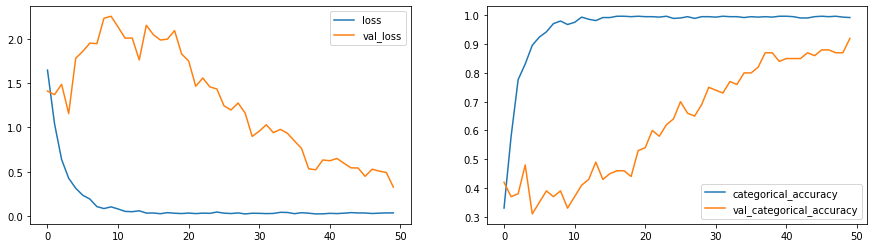

In [ ]:
plot(history)

### Experiment 72

In [ ]:
frames_used = 18
img_idx_tmp = np.round(np.linspace(0,29,frames_used)).astype(int)

print('frames_used=',frames_used)

mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(120, 120, 3))

for layer in mobilenetv2.layers[:-20]:
    layer.trainable=False

cnn = Sequential([mobilenetv2])
cnn.add(Flatten())

model = Sequential()
model.add(TimeDistributed(cnn, input_shape=(frames_used, 120, 120, 3)))
model.add(GRU(128, return_sequences=False))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))


optimiser = 'Adam'#write your optimizer   ## Check with RMSprop or others
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())  

frames_used= 18
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_20 (TimeDi  (None, 18, 20480)        2257984   
 stributed)                                                      
                                                                 
 gru_5 (GRU)                 (None, 128)               7914240   
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               16512     
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 5)                 645       
                                     

In [ ]:
curr_dt_time = datetime.datetime.now()

history = train_model(curr_dt_time, min_lr=0.0000000001, batch_size=20, train_doc_sample=train_doc,
                      val_doc_sample=val_doc, num_epochs=50, 
                      p_preprocess_input=False, model=model, img_idx=img_idx_tmp)

print('-----------------------')
print_best_epoc(history)

# training sequences = 663
# validation sequences = 100
Epoch 1/50
34/34 [==============================] - 63s 2s/step - loss: 1.8077 - categorical_accuracy: 0.2760 - val_loss: 1.4709 - val_categorical_accuracy: 0.3600 - lr: 0.0010
Epoch 2/50
34/34 [==============================] - 57s 2s/step - loss: 1.2441 - categorical_accuracy: 0.4842 - val_loss: 1.2814 - val_categorical_accuracy: 0.3600 - lr: 0.0010
Epoch 3/50
34/34 [==============================] - 57s 2s/step - loss: 0.8377 - categorical_accuracy: 0.6637 - val_loss: 1.1552 - val_categorical_accuracy: 0.4600 - lr: 0.0010
Epoch 4/50
34/34 [==============================] - 58s 2s/step - loss: 0.6082 - categorical_accuracy: 0.7436 - val_loss: 1.7102 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 5/50
34/34 [==============================] - 57s 2s/step - loss: 0.4942 - categorical_accuracy: 0.8009 - val_loss: 1.6615 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 6/50
34/34 [==============================] - 57s 2s/

In [ ]:
plot(history)

### Experiment 73

In [ ]:
frames_used = 18
img_idx_tmp = np.round(np.linspace(0,29,frames_used)).astype(int)

print('frames_used=',frames_used)

mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(120, 120, 3))

for layer in mobilenetv2.layers[:-20]:
    layer.trainable=False

cnn = Sequential([mobilenetv2])
cnn.add(Flatten())

model = Sequential()
model.add(TimeDistributed(cnn, input_shape=(frames_used, 120, 120, 3)))
model.add(GRU(128, return_sequences=False))
model.add(Dropout(0.6))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.6))

model.add(Dense(5, activation='softmax'))


optimiser = 'Adam'#write your optimizer   ## Check with RMSprop or others
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())  

frames_used= 18
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_22 (TimeDi  (None, 18, 20480)        2257984   
 stributed)                                                      
                                                                 
 gru_7 (GRU)                 (None, 128)               7914240   
                                                                 
 dropout_18 (Dropout)        (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 128)               16512     
                                                                 
 dropout_19 (Dropout)        (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 5)                 645       
                                     

In [ ]:
curr_dt_time = datetime.datetime.now()

history = train_model(curr_dt_time, min_lr=0.0000000001, batch_size=20, train_doc_sample=train_doc,
                      val_doc_sample=val_doc, num_epochs=50, 
                      p_preprocess_input=False, model=model, img_idx=img_idx_tmp)

print('-----------------------')
print_best_epoc(history)

# training sequences = 663
# validation sequences = 100
Epoch 1/50
34/34 [==============================] - 68s 2s/step - loss: 2.1101 - categorical_accuracy: 0.2519 - val_loss: 1.5798 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/50
34/34 [==============================] - 62s 2s/step - loss: 1.9343 - categorical_accuracy: 0.2338 - val_loss: 1.5912 - val_categorical_accuracy: 0.3100 - lr: 0.0010
Epoch 3/50
34/34 [==============================] - 60s 2s/step - loss: 1.6536 - categorical_accuracy: 0.3017 - val_loss: 1.6042 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 4/50
34/34 [==============================] - 62s 2s/step - loss: 1.4169 - categorical_accuracy: 0.4148 - val_loss: 1.5267 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 5/50
34/34 [==============================] - 62s 2s/step - loss: 1.1828 - categorical_accuracy: 0.5354 - val_loss: 1.6096 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 6/50
34/34 [==============================] - 60s 2s/

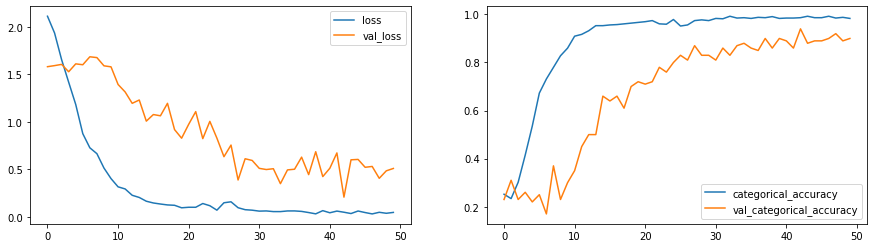

In [ ]:
plot(history)

### Final Model as per Experiment 72

In [47]:
frames_used = 18
img_idx_tmp = np.round(np.linspace(0,29,frames_used)).astype(int)

print('frames_used=',frames_used)

mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(120, 120, 3))

for layer in mobilenetv2.layers[:-20]:
    layer.trainable=False

cnn = Sequential([mobilenetv2])
cnn.add(Flatten())

model = Sequential()
model.add(TimeDistributed(cnn, input_shape=(frames_used, 120, 120, 3)))
model.add(GRU(128, return_sequences=False))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))


optimiser = 'Adam'#write your optimizer   ## Check with RMSprop or others
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())  

frames_used= 18
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_63 (TimeDi  (None, 18, 20480)        2257984   
 stributed)                                                      
                                                                 
 gru_6 (GRU)                 (None, 128)               7914240   
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               16512     
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 5)                 645       
                                      

In [48]:
curr_dt_time = datetime.datetime.now()

history = train_model(curr_dt_time, min_lr=0.0000000001, batch_size=20, train_doc_sample=train_doc,
                      val_doc_sample=val_doc, num_epochs=50, 
                      p_preprocess_input=False, model=model, img_idx=img_idx_tmp, 
                      save_model=True, model_name='MobileNet_Exp72')

print('-----------------------')
print_best_epoc(history)

# training sequences = 663
# validation sequences = 100
Epoch 1/50
34/34 [==============================] - ETA: 0s - loss: 1.8123 - categorical_accuracy: 0.2624
Epoch 00001: val_categorical_accuracy improved from -inf to 0.32000, saving model to /content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/model_output/MobileNet_Exp72_2022-01-2508_43_47.901635/model-00001-1.81232-0.26244-1.51448-0.32000.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


34/34 [==============================] - 67s 2s/step - loss: 1.8123 - categorical_accuracy: 0.2624 - val_loss: 1.5145 - val_categorical_accuracy: 0.3200 - lr: 0.0010
Epoch 2/50
34/34 [==============================] - ETA: 0s - loss: 1.2614 - categorical_accuracy: 0.4827
Epoch 00002: val_categorical_accuracy improved from 0.32000 to 0.50000, saving model to /content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/model_output/MobileNet_Exp72_2022-01-2508_43_47.901635/model-00002-1.26144-0.48265-1.30734-0.50000.h5
34/34 [==============================] - 58s 2s/step - loss: 1.2614 - categorical_accuracy: 0.4827 - val_loss: 1.3073 - val_categorical_accuracy: 0.5000 - lr: 0.0010
Epoch 3/50
34/34 [==============================] - ETA: 0s - loss: 0.8994 - categorical_accuracy: 0.6410
Epoch 00003: val_categorical_accuracy improved from 0.50000 to 0.56000, saving model to /content/gdrive/MyDrive/Colab Notebooks/Course25-GestureAssignment/Project_data/model_output/Mobil